In [1]:
from IPython.display import HTML

# This code bit is directly taken from this notebook: https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# House Prices: Advanced Regression Techniques

In this kernel, I play with [kaggle's house price data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). A description of the data by its collector, Dean De Cock, can be found [here](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf).

### Summary 

* I spent quite some time on filling in missing values
* I used only two models: Lasso and XGBoost. For both I conduct a residual analysis
* I set up a meta-model to offset the tails of the predictions of these models. 
* I considered two ways to combine the two models: simple averaging and an OLS meta-model

### Kudos

In the process, I had a look at a number of kernels by other users that I found very helpful. I found the following two particularly instructive. 
* [Kernel by Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [Kernel by Arun Godwin Patel](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook)
 
 
 
### Structure

1.  [First look at SalePrice](#Dependent-variable:-SalePrice)
  *  [Distribution](#Distribution)
  *  [Outliers](#Outliers)
2.  [Explanatory Variables](#Explanatory-Cariables)
  *  [Missing Values](#Missing-Values)
  *  [Feature Engineering and Variable Transformations](#Feature-Engineering-and-Variable-Transformations)
3.  [Modeling](#Modeling)
  *  [Lasso](#Lasso)
  *  [XGBoost](#XGBoost)
4.  [Combining Models](#Combining-Models)
  * [Model Averaging](#Model-Averaging)
  * [OLS Meta-Model](#OLS-Meta-Model)
  * [Averaging Meta-Models](#Averaging-Meta-Models)
5.  [Test Set Predictions](#Test-Set-Predictions)

In [2]:
# First imports
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('First imports loaded.')

#Turn off some annoying deprecation warnings
import warnings
warnings.warn = lambda *args, **kwargs: None
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warnings turned off.')

# Load the data
train_data = pd.read_csv('data/train.csv', index_col='Id')
test_data = pd.read_csv('data/test.csv', index_col='Id')
print('Data loaded.')
print('Training observations: {}'.format(train_data.shape[0]))
print('Test observations: {}'.format(test_data.shape[0]))

First imports loaded.
Deprecation warnings turned off.
Data loaded.
Training observations: 1460
Test observations: 1459


## Dependent variable: SalePrice

### Distribution

We take a first look at the *SalePrice*. 

In [3]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Mean sale price of 180k, minimum 35k and maximum 755k seems not believable. There is a high concentration in the interquartile range which spans only from 130k to 214k.

Moving on, we look at the distribution of the *SalePrice* in more detail. The histogram on the left is for the data on the original scale, the one on the right for log-data.

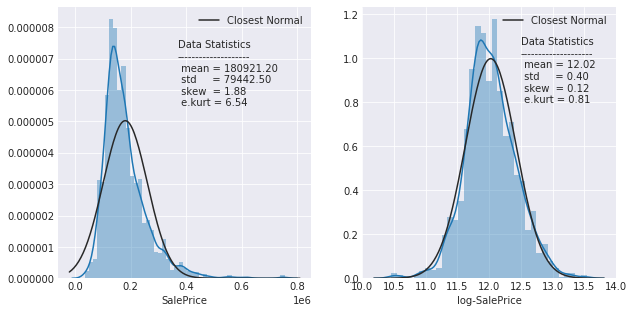

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.distplot(train_data['SalePrice'], fit=stats.norm, ax=ax[0])
sns.distplot(np.log(train_data['SalePrice']), fit=stats.norm, ax=ax[1])
ax[0].legend(['Closest Normal'])
ax[0].text(x=3.7e5, y=0.0000055, 
           s='Data Statistics\n--------------------\n' + 
           ' mean = {:.2f} \n std     = {:.2f}'.format(
               train_data['SalePrice'].mean(), train_data['SalePrice'].std()) + 
           '\n skew  = {:.2f} \n e.kurt = {:.2f}'.format(
               train_data['SalePrice'].skew(), train_data['SalePrice'].kurt())
          )
ax[1].legend(['Closest Normal'])
ax[1].text(x=12.5, y=0.8, 
           s='Data Statistics\n--------------------\n' + 
           ' mean = {:.2f} \n std     = {:.2f}'.format(
               np.log(train_data['SalePrice']).mean(), np.log(train_data['SalePrice']).std()) + 
           '\n skew  = {:.2f} \n e.kurt = {:.2f}'.format(
               np.log(train_data['SalePrice']).skew(), np.log(train_data['SalePrice']).kurt())
          )
ax[0].set_xlabel('SalePrice')
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1].set_xlabel('log-SalePrice')
plt.show()

While the distribution on the original scale is quite skewed as is common non-negative monetary data, the distribution of the log-*SalePrice* looks much more symmetric and normal. This in itself makes modeling on the log-scale appealing. However, this is also encouraged by the scoring metric: root mean square log-error.

### Outliers
We can find the following paragraph in the description of the data by its collector, Dean De Cock, that can be found [here](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf):

*Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.*

We plot *SalePrice* against *GrLivArea*. Four of the five outliers are clearly visible.

Number of training observations with more than 4000 sqft: 4


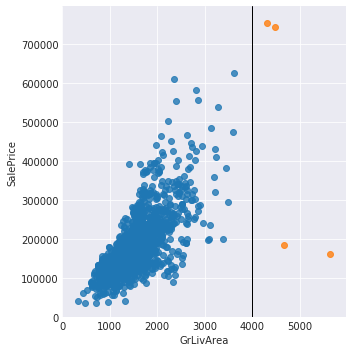

In [5]:
outlier_ID = train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index
unusual_ID = train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] > 300000)].index
sns.lmplot('GrLivArea', 'SalePrice', hue='Outliers', legend=False, fit_reg=False,
           data=pd.concat([train_data, (train_data['GrLivArea'] > 4000).rename('Outliers')], axis=1)
           )
plt.axvline(4000, color='black', linewidth=1)

print('Number of training observations with more than 4000 sqft: {}'.format(
    (train_data['GrLivArea'] > 4000).sum()))

Thus, we are missing one outlier in the training data. The fifth is in the test data.

In [6]:
print('Number of observations with more than 4000 sqft in the test set: {}'.format(
    (test_data['GrLivArea'] > 4000).sum()))

Number of observations with more than 4000 sqft in the test set: 1


Thus, all five outliers are accounted for.

From the plot, it becomes pretty clear which observations are the "unusual sales" mentioned in the article, namely 
the two observations with >4000 sqft and >700k sale price. These observations, at first sight, fall well in line with where we would expect them to be.
In contrast, the observations at or below 200k sale price are, at least in this comparison, quite clearly true outliers.
Thus, the fifth outlier must relate to a partial sale and we would consequently expect a rather low price for it. For this reason, we keep track of the average price of the partial sales in the training data for a manual correction of the prediction later on.

In [7]:
avg_large_partial_price = train_data.loc[outlier_ID, 'SalePrice'].mean()
print('The average sale price of the two unusual partial sales is ${:.0f}.'.format(avg_large_partial_price))

The average sale price of the two unusual partial sales is $172375.


Next, we  drop the four unusual observations from the training data.

In [8]:
train_data.drop(outlier_ID, inplace=True)
train_data.drop(unusual_ID, inplace=True)
print('Outliers dropped.')

Outliers dropped.


Finally, we define the dependent variable *y* as the log-*SalePrice* and drop it from the remaining data.

In [9]:
y_train = np.log(train_data['SalePrice'])
print('y_train defined as log-SalePrice.')
train_data.drop('SalePrice', axis=1, inplace=True)
print('SalePrice dropped from remaining data.')

y_train defined as log-SalePrice.
SalePrice dropped from remaining data.


## Explanatory Variables
Having looked at the sale price, we move on to the explanatory variables. For these, we merge train and test data. This way, we can do all operatins joinly on the entire data set. There is no danger in leaking information here since we do not have time-series data. Further, we do not use information on the *SalePrice*.

In [10]:
X = pd.concat([train_data, test_data])
print('Train and test data for explanatory variables merged.')

train_ID = train_data.index
test_ID = test_data.index
print('Training and test set ID stored.')

Train and test data for explanatory variables merged.
Training and test set ID stored.


We proceed by filling missing values in quite some details. This is followed by feature engineering and variable transformations.

### Missing Values
There are two kinds of missing values in the data: false positives and true missing values. 

#### "False positives"

From the *data_description.txt* we know that some of the variables denote the absence of a feature by *NA*. Thus, these value are not really missing. For these cases, we replace *NA* by *None*.

In [11]:
X_na_means_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                   'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                   'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

X.loc[:, X_na_means_none] = X.loc[:, X_na_means_none].fillna('None')
print('False positives fixed.')

False positives fixed.


#### True missing values

With the false positives fixed, we turn to the true missing values. There are some variables with a sizeable share of missing values.

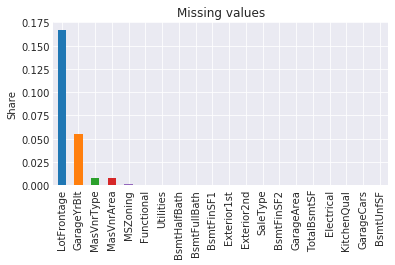

In [12]:
X_missing_perc = X.isnull().mean()[X.isnull().any()]
X_missing_perc.sort_values(ascending=False).plot.bar(figsize=(6,3))
plt.title('Missing values')
plt.ylabel('Share')
plt.show()

We work our way through this list in ascending order, collecting variables of similar type in one section.

##### Basement

We look at the following variables together

* *BsmtFinSF1*: finished square feet area type 1
* *BsmtFinSF2*: finished square feet area type 2
* *BsmtUnfSF*: unfinished square feet
* *TotalBsmtSF*: total area
* *BsmtFullBath*: number of full bathrooms
* *BsmtHalfBath*: number of half bathrooms

In [13]:
tmp = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

for var in tmp:
    print('Missing observations for {}: {}'.format(var, X[var].isnull().sum()))

Missing observations for BsmtFinSF1: 1
Missing observations for BsmtFinSF2: 1
Missing observations for BsmtUnfSF: 1
Missing observations for TotalBsmtSF: 1
Missing observations for BsmtFullBath: 2
Missing observations for BsmtHalfBath: 2


All the missing values come from only two observations.

In [14]:
X.loc[X[tmp].isnull().any(axis=1), tmp]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN
2189,0.0,0.0,0.0,0.0,NaN,NaN


*ID 2819* does have no squarefeet in the basement. Thus, we assume that there is no basement and thus no basement bathroom. 

In [15]:
X.loc[2189,['BsmtFullBath', 'BsmtHalfBath']] = 0
print('ID 2819 fixed.')

ID 2819 fixed.


*ID 2121* does not have data for all the basemenet variables in question. We look if there is meaningful data for any other basement variables.

In [16]:
X.loc[2121, [col for col in X.columns if 'Bsmt' in col]]

BsmtQual        None
BsmtCond        None
BsmtExposure    None
BsmtFinType1    None
BsmtFinSF1       NaN
BsmtFinType2    None
BsmtFinSF2       NaN
BsmtUnfSF        NaN
TotalBsmtSF      NaN
BsmtFullBath     NaN
BsmtHalfBath     NaN
Name: 2121, dtype: object

Recalling that we coded the variables showing "None" ourselves in the false positives sections, there is no information here.

Rather than the absence of a basement, this truly could be a missing observation that is just indistinguishable.

We look whether similar houses usually have a basement. By similar, we somewhat arbitrarily choose houses in the same *Neighborhood* and *MSSubClass* built within plus minus five years of the house's *YearBuilt*. This yields three observations other than *ID 2121*.

In [17]:
X.loc[((X['Neighborhood'] == X.loc[2121, 'Neighborhood'])
       & (X['MSSubClass'] == X.loc[2121, 'MSSubClass'])
       & (X['YearBuilt'] >= X.loc[2121, 'YearBuilt'] - 5)
       & (X['YearBuilt'] <= X.loc[2121, 'YearBuilt'] + 5)), 
      ['GrLivArea', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 
       'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFullBath', 
       'BsmtHalfBath']]

,GrLivArea,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,
534,334,None,None,None,0.0,0.0,0.0,0.0,0.0
1322,720,None,None,None,0.0,0.0,0.0,0.0,0.0
2121,896,None,None,None,NaN,NaN,NaN,NaN,NaN
2399,666,Fa,LwQ,No,299.0,0.0,666.0,0.0,1.0


Looking at this, we can justify filling the missing values with zeros. There is a 2:1 vote against a basement, even though the house in question is somewhat larger than the other three observations.

In [18]:
X.loc[2121,['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath']] = 0.
print('ID 2121 fixed.')
print('Basement missing values filled.')

ID 2121 fixed.
Basement missing values filled.


##### SaleType

Next we look at the *SaleType*.

In [19]:
print('Missing observations for {}: {}'.format('SaleType', X['SaleType'].isnull().sum()))

Missing observations for SaleType: 1


Again just one missing observation. We first find the observation.

In [20]:
X.loc[X['SaleType'].isnull(), ['SaleType', 'YrSold', 'SaleCondition']]

,SaleType,YrSold,SaleCondition
Id,,,
2490,NaN,2007,Normal


*WD* (Warranty Deed - Conventional) is by far the most common *SaleType*.

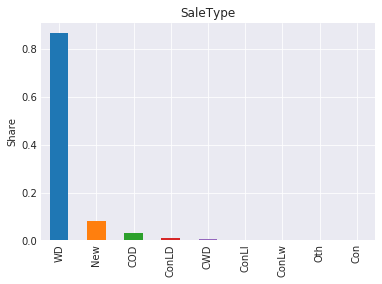

In [21]:
(X['SaleType'].value_counts()/X['SaleType'].count()).plot.bar()
plt.title('SaleType')
plt.ylabel('Share')
plt.show()

Still, we proceed as above and fill in a nearest neighbor type manner. We match on *Neighboorhood*, *MSSubClass*, *YrSold* and *SaleCondition*.

There are 24 neighboring observations.


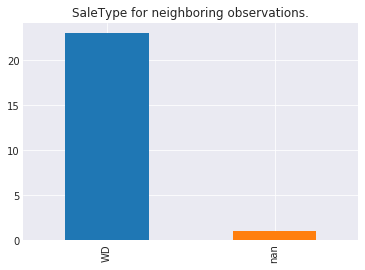

In [22]:
tmp = X.loc[((X['Neighborhood'] == X.loc[2490, 'Neighborhood'])
             & (X['MSSubClass'] == X.loc[2490, 'MSSubClass'])
             & (X['YrSold'] == X.loc[2490, 'YrSold'])
             & (X['SaleCondition'] == X.loc[2490, 'SaleCondition']))]['SaleType']

print('There are {} neighboring observations.'.format(len(tmp)))
tmp.value_counts(dropna=False).plot.bar()
plt.title('SaleType for neighboring observations.')
plt.show()

All similar houses had SaleType *WD* as well, so this is how we fill.

In [23]:
X.loc[2490, 'SaleType'] = 'WD'
print('SaleType missing values filled.')

SaleType missing values filled.


##### KitchenQual

In [24]:
print('Missing observations for {}: {}'.format('KitchenQual', X['KitchenQual'].isnull().sum()))

Missing observations for KitchenQual: 1


We find the observation.

In [25]:
X.loc[X['KitchenQual'].isnull(), ['KitchenAbvGr', 'KitchenQual']]

,KitchenAbvGr,KitchenQual
Id,,
1556,1,NaN


And again find similar observations. We match on *Neighboorhood* and *MSSubClass* and look at values of a couple other variables for those matches too.

In [26]:
X.loc[((X['Neighborhood'] == X.loc[1556, 'Neighborhood'])
       & (X['MSSubClass'] == X.loc[1556, 'MSSubClass'])), 
      ['GrLivArea', 'OverallQual', 'OverallCond', 'KitchenQual', 'KitchenAbvGr']]

,GrLivArea,OverallQual,OverallCond,KitchenQual,KitchenAbvGr
Id,,,,,
70,2287,7,4,TA,1
250,2144,6,7,Gd,1
372,1588,4,4,TA,1
849,2358,6,8,TA,1
1174,3086,5,6,Ex,1
1263,1788,4,5,TA,1
1556,1224,5,3,NaN,1


In this match, the observation in question has the fewest square feet and the lowest overall condition. Thus we would fill with either a typical kitchen quality (the mode). We could consider an even lower quality rating as feasible, but go for average here.

In [27]:
X.loc[X['KitchenQual'].isnull(), 'KitchenQual'] = 'TA'
print('KitchenQual missing values filled.')

KitchenQual missing values filled.


##### Garage

Next, we look at missing observations for garage related variables together.

* *GarageCars*: size of the garage in car capacity
* *GarageArea*: size of garage in square feet
* *GarageYrBlt*: year garage was built

In [28]:
tmp = ['GarageCars', 'GarageArea', 'GarageYrBlt']

for var in tmp:
    print('Missing observations for {}: {}'.format(var, X[var].isnull().sum()))

Missing observations for GarageCars: 1
Missing observations for GarageArea: 1
Missing observations for GarageYrBlt: 159


First, we consider the missing value for cars and area. The missing values relate to the same observations.

In [29]:
X.loc[X[['GarageCars', 'GarageArea']].isnull().any(axis=1),
     [col for col in X.columns if 'Garage' in col]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
Id,,,,,,,
2577,Detchd,NaN,None,NaN,NaN,None,None


We Recall that the "None" values were filled in by us so have no information content. However, *GarageType* is *Detchd* indicating that there is a garage.

We look at similar houses, matching on *Neighborhood*, *MSSubClass*, *GarageType* and *YearBuilt* plus minus 10 years.

In [30]:
tmp = X.loc[((X['Neighborhood'] == X.loc[2577, 'Neighborhood'])
       & (X['MSSubClass'] == X.loc[2577, 'MSSubClass'])
       & (X['GarageType'] == X.loc[2577, 'GarageType'])
       & (X['YearBuilt'] >= X.loc[2577, 'YearBuilt'] - 10)
       & (X['YearBuilt'] <= X.loc[2577, 'YearBuilt'] + 10)), 
      ['LotArea', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish',
      'GarageQual', 'GarageType', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']]

tmp

,LotArea,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
31,8500,250.0,1.0,Fa,Unf,TA,Detchd,1920.0,1920,1950
330,6402,189.0,1.0,Fa,Unf,Fa,Detchd,1920.0,1920,1950
366,10690,468.0,1.0,Fa,Unf,TA,Detchd,1964.0,1920,1997
2220,9000,216.0,1.0,Fa,Unf,Fa,Detchd,1920.0,1920,1950
2577,9060,NaN,NaN,None,None,None,Detchd,NaN,1923,1999


We fill in numerical missing values by means and categorical values by mode. An exception arises from *GarageYrBlt* which we fill in with the *YearBuilt*, following the majority of the other houses. For *GarageQual* we break the tie between fair and average in favor of average, taking into account that the house in question was remodelled failry recently.

In [31]:
X.loc[2577, 'GarageArea'] = tmp['GarageArea'].mean()
X.loc[2577, 'GarageCars'] = tmp['GarageCars'].mean()
X.loc[2577, 'GarageCond'] = tmp['GarageCond'].mode()[0]
X.loc[2577, 'GarageFinish'] = tmp['GarageFinish'].mode()[0]
X.loc[2577, 'GarageQual'] = 'TA'
X.loc[2577, 'GarageYrBlt'] = X.loc[2577, 'YearBuilt'] 

Now we move on to the missing values for *GarageYrBlt*. A reasonable suspicion is that missing values indicate the absence of a garage here.

In [32]:
print('Missing observations for {}: {}'.format('GarageYrBlt', X['GarageYrBlt'].isnull().sum()))
print('of which have no garage: {}'.format(X['GarageYrBlt'].isnull()[X['GarageArea'] == 0].sum()))

Missing observations for GarageYrBlt: 158
of which have no garage: 157


For the 157 observations which have neither *GarageYrBlt* nor a positive *GarageArea*, we fill the missing year with 0.

In [33]:
X.loc[X['GarageYrBlt'].isnull() & (X['GarageArea'] == 0), 'GarageYrBlt'] = 0.

Finally, we look at the observation with the remaining missing value.

In [34]:
X.loc[X['GarageYrBlt'].isnull(), 
      ['LotArea', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish',
      'GarageQual', 'GarageType', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']]

,LotArea,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
2127,8094,360.0,1.0,None,None,None,Detchd,NaN,1910,1983


It looks like this observation has a garage, given the *GarageType* is *Detchd*. Thus, we need to adjust *GarageCond* etc. We look at the observations neighbors once again, matching on *Neighborhood*, *MSSubClass* and *GarageType* in this case. Matching on *YearBuilt* turns out to be too stringent since the house in question is quite old.

In [35]:
tmp = X[X['GarageYrBlt'].isnull()].index[0]

X.loc[((X['Neighborhood'] == X.loc[tmp, 'Neighborhood'])
       & (X['MSSubClass'] == X.loc[tmp, 'MSSubClass'])
       & (X['GarageType'] == X.loc[tmp, 'GarageType'])), 
      ['LotArea', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish',
      'GarageQual', 'GarageType', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']]

,LotArea,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
426,3378,240.0,1.0,TA,Unf,TA,Detchd,1947.0,1946,1992
1783,10800,720.0,2.0,TA,Unf,TA,Detchd,1939.0,1939,2006
2127,8094,360.0,1.0,None,None,None,Detchd,NaN,1910,1983


We fill in by majority vote or for garage year built by year built.

In [36]:
X.loc[2127, 'GarageCond'] = 'TA'
X.loc[2127, 'GarageQual'] = 'TA'
X.loc[2127, 'GarageFinish'] = 'Unf'
X.loc[2127, 'GarageYrBlt'] = X.loc[2127, 'YearBuilt']

Before moving on, we correct a clear mistake in *GarageYrBuilt*:

In [37]:
print('Largest GarageYrBlt: {:.0f}'.format(X['GarageYrBlt'].max()))

Largest GarageYrBlt: 2207


We look at the remaining year related time information for the observation in question.

In [38]:
X.loc[X['GarageYrBlt'].idxmax(), ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
                                  'YrSold']]

YearBuilt       2006
YearRemodAdd    2007
GarageYrBlt     2207
YrSold          2007
Name: 2593, dtype: object

It seems fairly reasonable to assume a typo which was meant to say *2007* so this is what we set it to.

In [39]:
X.loc[2593, 'GarageYrBlt'] = 2007

In [40]:
print('Garage missing values filled.')

Garage missing values filled.


##### Electrical

In [41]:
print('Missing observations for {}: {}'.format('Electrical', X['Electrical'].isnull().sum()))

Missing observations for Electrical: 1


In the same process as before, we find the observations and compare it to its neighbors. Here, we match on *Neighborhood* and *MSSubClass* again.

In [42]:
X.loc[((X['Neighborhood'] == X.loc[1380, 'Neighborhood'])
       & (X['MSSubClass'] == X.loc[1380, 'MSSubClass'])), 
      ['GrLivArea','LotArea', 'YearBuilt', 'YearRemodAdd', 
       'Electrical', 'Heating', 'CentralAir']]

,GrLivArea,LotArea,YearBuilt,YearRemodAdd,Electrical,Heating,CentralAir
Id,,,,,,,
531,1509,10200,1988,1989,SBrkr,GasA,Y
732,1146,9590,2003,2003,SBrkr,GasA,Y
1380,1394,9735,2006,2007,NaN,GasA,Y
1924,1479,14419,1987,1989,SBrkr,GasA,Y
2230,1442,9802,2006,2007,SBrkr,GasA,Y


All matches have *SBrkr* (Standard Circuit Breakers & Romex). This is what we fill the missing value with.

In [43]:
X.loc[1380, 'Electrical'] = 'SBrkr'
print('Electrical missing values filled.')

Electrical missing values filled.


##### Exterior

We look at missing values for
* *Exterior1st*: Exterior covering on house
* *Exterior2nd*: Exterior covering on house (if more than one material)

together.

In [44]:
print('Missing observations for {}: {}'.format('Exterior1st', X['Exterior1st'].isnull().sum()))
print('Missing observations for {}: {}'.format('Exterior2nd', X['Exterior2nd'].isnull().sum()))

Missing observations for Exterior1st: 1
Missing observations for Exterior2nd: 1


The missing values here relate to the same observation.

In [45]:
X.loc[X['Exterior1st'].isnull(), 
      ['GrLivArea', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'Foundation', 'RoofMatl', 'RoofStyle', 'YearBuilt',
       'YearRemodAdd']]

,GrLivArea,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,RoofMatl,RoofStyle,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
2152,1518,NaN,NaN,TA,TA,PConc,Tar&Grv,Flat,1940,2007


It does not seem unreasonable to assume that there is a relation between the exterior covering and *RoofMatl*. 
It turns out that the roof material is rather rare in the data. It seems appropriate so see whether there is a correlation between the roof material and the exterior material.

In the barplots for *Exterior1st* and *Exterior2nd* below, we can make out a very similar trend with *VinylSd* (Vinyl Siding) being by far the most common. For *RoofMatl*, *CompShg* (Standard (Composite) Shingle) is by far the most common. We can also see that *Tar&Grv* is the second most common *RoofMatl* even though there are very few occurences (23 to be precise). We can, however, see that *VinylSd* is somewhat negatively correlated with *Tar&Grv* while *Plywood* is positively correlated. 

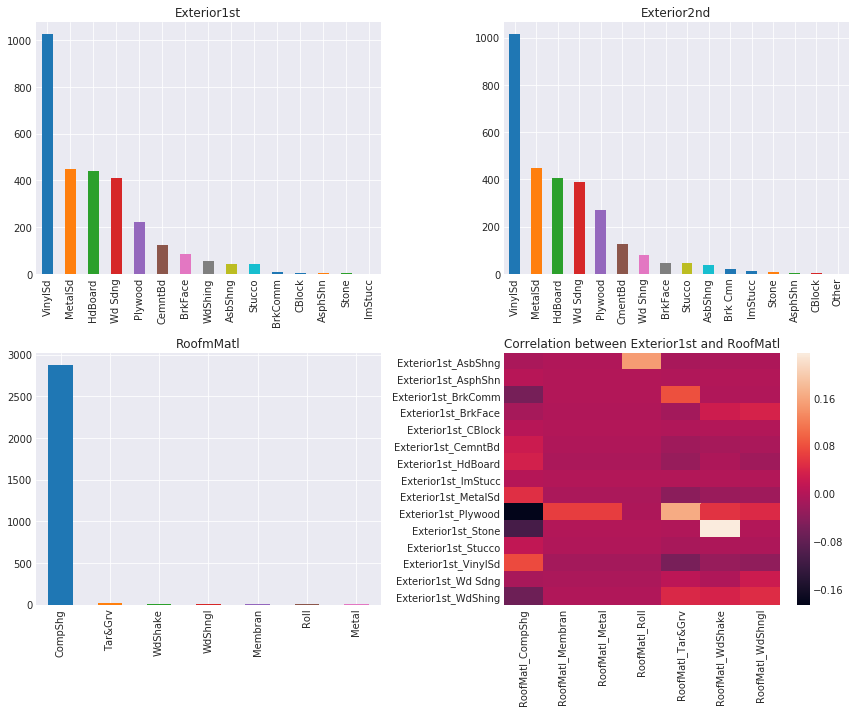

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
X['Exterior1st'].value_counts().plot.bar(ax=ax[0,0])
ax[0,0].set_title('Exterior1st')
X['Exterior2nd'].value_counts().plot.bar(ax=ax[0,1])
ax[0,1].set_title('Exterior2nd')
X['RoofMatl'].value_counts().plot.bar(ax=ax[1,0])
ax[1,0].set_title('RoofmMatl')

tmp = pd.get_dummies(X[['Exterior1st', 'RoofMatl']]).corr()
sns.heatmap(tmp.loc[[var for var in tmp.index if 'Exterior' in var], [var for var in tmp.columns if 'Roof' in var]], ax=ax[1,1])
ax[1,1].set_title('Correlation between Exterior1st and RoofMatl')

fig.tight_layout()

Looking at the exterior materials occuring with *Tar&Grv* in more detail, we can see that *PlyWood* is by far the most common for both *Exterior1st* and *Exterior2nd*

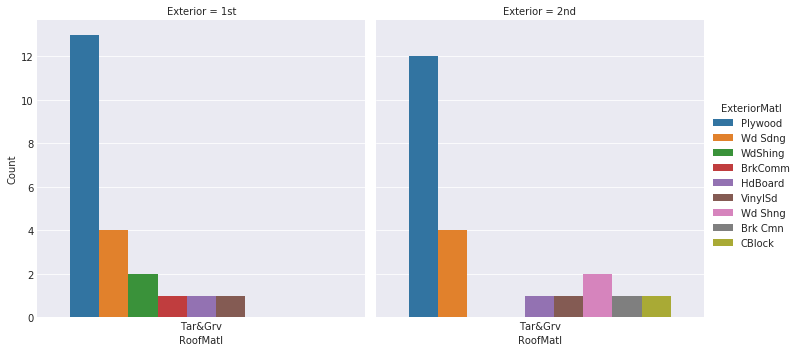

In [47]:
tmp1 = pd.DataFrame(X.groupby('RoofMatl')['Exterior1st'].value_counts(dropna=False))
tmp1['Exterior'] = '1st'
tmp1.columns = ['Count', 'Exterior']
tmp1.reset_index(inplace=True)
tmp1.columns = ['RoofMatl', 'ExteriorMatl', 'Count', 'Exterior']
tmp2 = pd.DataFrame(X.groupby('RoofMatl')['Exterior2nd'].value_counts())
tmp2['Exterior'] = '2nd'
tmp2.columns = ['Count', 'Exterior']
tmp2.reset_index(inplace=True)
tmp2.columns = ['RoofMatl', 'ExteriorMatl', 'Count', 'Exterior']
tmp = pd.concat([tmp1, tmp2])
tmp = tmp[tmp['RoofMatl'].isin(['Tar&Grv'])]
tmp

sns.factorplot(x="RoofMatl", y="Count",
                    hue="ExteriorMatl", col="Exterior",
                    data=tmp, kind="bar")
plt.show()

Thus we fill the missing values for the exterior material with *Plywood*

In [48]:
X.loc[2152, ['Exterior1st', 'Exterior2nd']] = 'Plywood'
print('Exterior missing values filled.')

Exterior missing values filled.


#### Functional
Defined as "Home functionality (Assume typical unless deductions are warranted)"

In [49]:
print('Missing observations for {}: {}'.format('Functional', X['Functional'].isnull().sum()))

Missing observations for Functional: 2


Looking at the observations, we see that both of them are either in a poor *OverallCond* or have poor *OverallQual*. Also, both houses are in the same neighborhood.

In [50]:
X.loc[X['Functional'].isnull(), 
      ['Neighborhood', 'MSSubClass', 'YearBuilt', 'YearRemodAdd',
       'OverallQual', 'OverallCond', 'Functional']]

,Neighborhood,MSSubClass,YearBuilt,YearRemodAdd,OverallQual,OverallCond,Functional
Id,,,,,,,
2217,IDOTRR,20,1952,1952,1,5,NaN
2474,IDOTRR,50,1910,1950,4,1,NaN


We look at the functionality of other houses with either poor quality of condition.

In [51]:
X.loc[((X['Neighborhood'] == 'IDOTRR')
       & (X['OverallQual'] == 1) | (X['OverallCond'] == 1)), 
      ['Functional', 'OverallQual', 'OverallCond']]

,Functional,OverallQual,OverallCond
Id,,,
376,Maj1,1,1
1559,Typ,4,1
1832,Sev,5,1
2100,Maj2,3,1
2106,Maj1,2,1
2217,NaN,1,5
2251,Maj1,5,1
2474,NaN,4,1


Except for one observation, all these have major deductions or worse. Thus, it seems appropriate to consider at least major deductions. From the two available levels, *Maj1* and *Maj2*, we opt for the less severe one since both houses have either average *OverallQual* or average *OverallCond*.

In [52]:
X.loc[X['Functional'].isnull(), 'Functional'] = 'Maj1'
print('Functional missing values filled.')

Functional missing values filled.


#### Utilities

In [53]:
print('Missing observations for {}: {}'.format('Utilities', X['Utilities'].isnull().sum()))

Missing observations for Utilities: 2


For *Utilities*, there is only a single observation that is not  *AllPub*.

In [54]:
print('Number of occurences of Utilities categories')
print('--------------------------------------------')
X['Utilities'].value_counts()

Number of occurences of Utilities categories
--------------------------------------------


AllPub    2912
NoSeWa       1
Name: Utilities, dtype: int64

Thus, we fill in by *AllPub*.

In [55]:
X.loc[X['Utilities'].isnull(), 'Utilities'] = 'AllPub'
print('Utilities missing values filled.')

Utilities missing values filled.


#### MSZoning

In [56]:
print('Missing observations for {}: {}'.format('MSZoning', X['MSZoning'].isnull().sum()))

Missing observations for MSZoning: 4


Wee find the missing observations. It seems sensible to also look at the *Neighborhood* and *MSSubClass*.

In [57]:
X.loc[X['MSZoning'].isnull(), ['Neighborhood', 'MSSubClass', 'MSZoning']]

,Neighborhood,MSSubClass,MSZoning
Id,,,
1916,IDOTRR,30,NaN
2217,IDOTRR,20,NaN
2251,IDOTRR,70,NaN
2905,Mitchel,20,NaN


We look at the general distribution of zoning, as well as *MSZoning* in the *Neighborhood*-*MSSubClass* combinations of the missing observations.

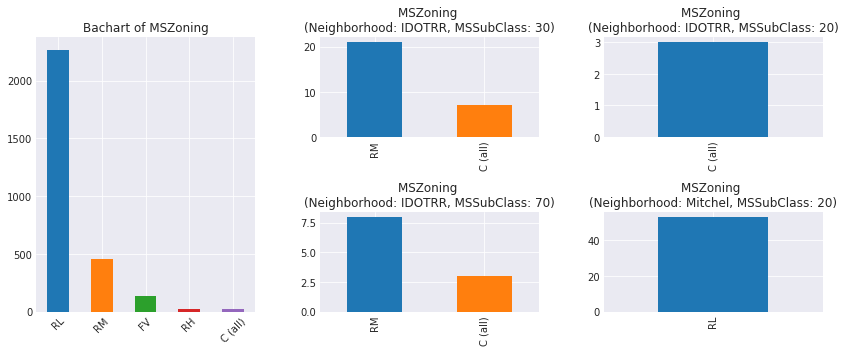

In [58]:
gridsize = (2, 3)
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))
ax4 = plt.subplot2grid(gridsize, (1, 1))
ax5 = plt.subplot2grid(gridsize, (1, 2))

X['MSZoning'].value_counts().plot.bar(rot=45, ax=ax1)
ax1.set_title('Bachart of MSZoning')

ax = [ax2, ax3, ax4, ax5]

for i, comb in enumerate([('IDOTRR', 30), ('IDOTRR', 20),
                          ('IDOTRR', 70), ('Mitchel', 20)]):
    X.loc[(X['Neighborhood'] == comb[0]) & (X['MSSubClass'] == comb[1]), 'MSZoning'].value_counts().plot.bar(ax = ax[i])
    ax[i].set_title('MSZoning \n(Neighborhood: {}, MSSubClass: {})'.format(comb[0], str(comb[1]))) 
    
fig.tight_layout()

It does indeed look like zoning has something to do with neighborhood and subclass.
We now fill in by majority vote, noting that this differs from the most common overall class *RL* for three out of the four combinations.

In [59]:
X.loc[1916, 'MSZoning'] = 'RM'
X.loc[2217, 'MSZoning'] = 'C (all)'
X.loc[2251, 'MSZoning'] = 'RM'
X.loc[2905, 'MSZoning'] = 'RL'
print('MSSubClass missing values filled.')

MSSubClass missing values filled.


#### Masonry Veneer

We look at 
* *MasVnrType*: Masonry veneer type
* *MasVnrArea*: Masonry veneer area in square feet

together.

Before we look at the missing observations, we notice something peculiar.
* For *MasVnrType = None* we should have *MasVnrArea = 0*
* For *MasVnrArea = 0* we should have *MasVnrType = None*

However, this is not always the case.

In [60]:
X.groupby('MasVnrType')['MasVnrArea'].describe()

,count,mean,std,min,25%,50%,75%,max
MasVnrType,,,,,,,,
BrkCmn,25.0,195.480000,160.361082,40.0,67.0,161.0,250.0,621.0
BrkFace,878.0,260.637813,208.205694,0.0,120.0,203.0,340.0,1600.0
None,1741.0,0.707639,14.758208,0.0,0.0,0.0,0.0,344.0
Stone,247.0,235.182186,174.095488,0.0,119.5,200.0,297.5,1224.0


This affects just a couple observations.

In [61]:
X.loc[(((X['MasVnrArea'] > 0) & (X['MasVnrType'] == 'None'))
       |((X['MasVnrArea'] == 0) & (X['MasVnrType'] != 'None'))), 
      ['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
Id,,
625,288.0,None
689,0.0,BrkFace
774,1.0,None
1231,1.0,None
1242,0.0,Stone
1301,344.0,None
1335,312.0,None
1670,285.0,None
2320,0.0,BrkFace


We deal with this as follows.
* We set *MasVnrType* to *None* for those observations with *MasVnrArea = 0*.
* We set the *MasVnrArea* to zero for observations with *MasVnrType = None*
* For the observations with *MasVnrType = None* and *MasVnrArea = 1*, we also set *MasVnrArea* to zero
* For observations with a *MasVnrArea > 1* and *MasVnrType = None*, we set the *MasVnrType* to *NA* and include them in our treatment for missing values below.

In [62]:
X.loc[((X['MasVnrArea'] == 0) & (X['MasVnrType'] != 'None')), 'MasVnrType'] = 'None'
X.loc[((X['MasVnrArea'] == 1) & (X['MasVnrType'] == 'None')), 'MasVnrArea'] = 0.
X.loc[((X['MasVnrArea'] > 1) & (X['MasVnrType'] == 'None')), 'MasVnrType'] = np.nan

This leaves us with the following number of missing values.

In [63]:
print('Missing observations for {}: {}'.format('MasVnrArea', X['MasVnrArea'].isnull().sum()))
print('Missing observations for {}: {}'.format('MasVnrType', X['MasVnrType'].isnull().sum()))

Missing observations for MasVnrArea: 23
Missing observations for MasVnrType: 28


We suspect that the missing observations generally overlap between missing values for *MasVnrArea* and *MasVnrType*. This is confirmed.

In [64]:
tmp = X.loc[X[['MasVnrArea', 'MasVnrType']].isnull().any(axis=1), ['MasVnrArea', 'MasVnrType']]
print('Total number of missing observations in either MasVnrArea or MasVnrType: {}'.format(tmp.shape[0]))

Total number of missing observations in either MasVnrArea or MasVnrType: 28


* We match on *Neighborhood* and *MSSubClass*
* We fill the missing value for *MasVnrType* by the mode of neighboring observations
* If *MasVnrArea* is missing, we set *MasVnrArea* to zero if *MasVnrType = None*, otherwise we fill by the median

In [65]:
for i in tmp.index:
    tmp2 = X.loc[((X['Neighborhood'] == X.loc[i, 'Neighborhood'])
                  & (X['MSSubClass'] == X.loc[i, 'MSSubClass'])), 
                 ['MasVnrType', 'MasVnrArea']]
    mode = tmp2['MasVnrType'].mode()[0]
    X.loc[i, 'MasVnrType'] = mode
    if np.isnan(X.loc[i, 'MasVnrArea']):
        if mode == 'None':
            X.loc[i, 'MasVnrArea'] = 0.
        else:
            X.loc[i, 'MasVnrArea'] = tmp2.loc[tmp2['MasVnrType'] == mode].median()[0]

print('Masonry Veneer missing values filled.')

Masonry Veneer missing values filled.


#### LotFrontage

In [66]:
print('Missing observations for {}: {}'.format('LotFrontage', X['LotFrontage'].isnull().sum()))

Missing observations for LotFrontage: 486


Now we have somewhat too many observations do deal with them one by one. It seems reasonable, however, to assume that *LotFrontage* and *LotArea* are related. In the scatterplot below, it does indeed look like this is the case.

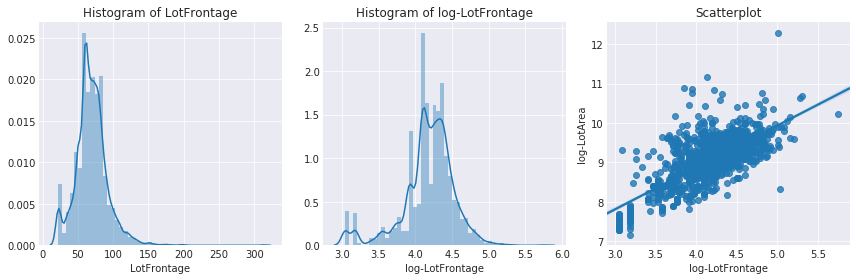

In [67]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

sns.distplot(X.loc[X['LotFrontage'].notnull(), 'LotFrontage'], ax=ax[0])
ax[0].set_title('Histogram of LotFrontage')

sns.distplot(X.loc[X['LotFrontage'].notnull(), 'LotFrontage'].apply(np.log), ax=ax[1])
ax[1].set_title('Histogram of log-LotFrontage')
ax[1].set_xlabel('log-LotFrontage')

sns.regplot(x='LotFrontage', y='LotArea', data=X.loc[X['LotFrontage'].notnull(), ['LotArea', 'LotFrontage']].apply(np.log), ax=ax[2])
ax[2].set_title('Scatterplot')
ax[2].set_xlabel('log-LotFrontage')
ax[2].set_ylabel('log-LotArea')

fig.tight_layout()

Thus, we use of a very simple regression model, regressing log-*LotFrontage* on log-*LotArea*, also throwing in *LotConfig* and *Neighborhood* dummies for good measure. The fit of this regression is not bad. We use this regression to fill in the missing values.

In [68]:
from sklearn.linear_model import LinearRegression

tmp = pd.get_dummies(X[['LotFrontage', 'LotArea', 'LotConfig', 'Neighborhood']])
tmp.loc[:,['LotFrontage', 'LotArea']] = np.log(tmp.loc[:,['LotFrontage', 'LotArea']])
tmp2 = LinearRegression()
tmp2.fit(tmp.dropna().drop('LotFrontage', axis=1), tmp.dropna()['LotFrontage'])
print('R2 of the regression: {:.2f}'.format(
    tmp2.score(tmp.dropna().drop('LotFrontage', axis=1), tmp.dropna()['LotFrontage']))
     )

tmp3 = tmp2.predict(tmp.loc[tmp.isnull().any(axis=1),:].drop('LotFrontage', axis=1))

X.loc[tmp.isnull().any(axis=1), 'LotFrontage'] = np.exp(tmp3)

print('LotFrontage missing values filled.')

R2 of the regression: 0.71
LotFrontage missing values filled.


With this, we have dealt with all missing values.

In [69]:
print('Number of remaining missing values: {}'.format(X.isnull().sum().sum()))

Number of remaining missing values: 0


### Feature Engineering and Variable Transformations
Having dealt with the missing values, we now consider feature engineering and variable transformations, such as creating dummies or taking logs. Before we do so, we allocate the variables into a number of categories that we treat seperately.

#### Variable Categories
We consider the following categories.

* Cardinal & continuous: things like areas in sqft or money
* Cardinal & discrete: things like the number of rooms or fireplaces
* Ordinal: this includes mostly variables relating to quality and condition
* Nominal: things that don't have any kind of obvious ordering, such as the neighborhood.
* Time: we treat time related variables, such as the year in which the house was sold, separately.

*Remark: we allocate *Fence* to nominal since it mixes quality and privacy.*


In [70]:
nominal = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 
           'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
           'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
           'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
           'MasVnrType', 'Foundation', 'Heating', 'GarageType', 
           'PavedDrive', 'Fence', 'MiscFeature', 'SaleType',
           'SaleCondition']
print('Nominal variables allocated.')

ordinal = ['Utilities', 'OverallQual', 'OverallCond', 'ExterQual',
           'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
           'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
           'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']
print('Ordinal variables allocated.')

card_cont = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
             '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch', 'PoolArea', 'MiscVal']
print('Continuous cardinal variables allocated.')

card_disc = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
             'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
             'GarageCars']
print('Discrete cardinal variables allocated.')

time = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
print('Time variables allocated.')

tmp = [var for l in [card_cont, card_disc, ordinal, nominal, time] for var in l]
if (pd.Series(tmp).sort_values() 
    == pd.Series(X.columns).sort_values().values).all():
    print('All variables allocated.')

Nominal variables allocated.
Ordinal variables allocated.
Continuous cardinal variables allocated.
Discrete cardinal variables allocated.
Time variables allocated.
All variables allocated.


#### Feature engineering

We generate a few new variables that we think may be useful. 

Three time features:
* *YrBlt_to_sold*: the difference between *YrSold* and *YearBuilt*
* *YrRemod_to_sold*: the difference between *YrSold* and *YearRemodAdd*
* *GrgYrBlt_to_sold*: the difference between *YrSold* and *GarageYrBlt*

One continuous cardinal feature:
* *TotalSqFt*: The sum of *GrLivArea* and *TotalBsmtSF*, thus the total indoor area

In [71]:
X['YrBlt_to_sold'] = X['YrSold'] - X['YearBuilt']
X['YrRemod_to_sold'] = X['YrSold'] - X['YearRemodAdd']
X['GrgYrBlt_to_sold'] = X['YrSold'] - X['GarageYrBlt']
time.append('YrBlt_to_sold')
time.append('YrRemod_to_sold')
time.append('GrgYrBlt_to_sold')

X['TotalSqFt'] = X['GrLivArea'] + X['TotalBsmtSF']
card_cont.append('TotalSqFt')

#### Variable Transformations

We work through the categories one by one. On the way, we generate two separate sets of regressors. 
* For linear regression models, we create dummies for nominal features and create monotone transformations
* For non-linear tree-based models such as XGBoost, we instead label-encode nominal features and do not include monotone transformations.

The idea is to keep the number of variables somewhat smaller for tree-based models which can intrinsically handle non-linearities. For the linear model, we have to provide somewhat more support.

##### Nominal

We perform the following transformations.
* Dummies for linear models
* Label-encoding for non-linear models.

In [72]:
X_transformed_lin = []
X_nom_dummied = pd.get_dummies(X[nominal].astype(object), drop_first=True)
X_transformed_lin.append(X_nom_dummied)

X_transformed_nonlin = []
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_nom_labeled = X[nominal].astype(object).apply(le.fit_transform)
X_transformed_nonlin.append(X_nom_labeled)

print('Nominal variables transformed.')

Nominal variables transformed.


##### Ordinal

Here, we consider a few transformations.

* Label-encoding while explicitly preserving ordinality (both linear and non-linear)
* Squares and cubes of label encoded variables (linear)
* Dummies (linear)

In [73]:
X_ord_label = X[ordinal].copy()

X_ord_label['Utilities'].replace({'AllPub': 3, 'NoSeWr': 2, 'NoSeWa': 1, 'ELO': 0}, inplace=True)

X_ord_label['ExterQual'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}, inplace=True)
X_ord_label['ExterCond'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}, inplace=True)

X_ord_label['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, inplace=True)
X_ord_label['BsmtFinType1'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, inplace=True)
X_ord_label['BsmtFinType2'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, inplace=True)

X_ord_label['HeatingQC'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}, inplace=True)

X_ord_label['CentralAir'].replace({'N': 0, 'Y': 1}, inplace=True)

X_ord_label['Electrical'].replace({'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0}, inplace=True)

X_ord_label['KitchenQual'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}, inplace=True)

X_ord_label['Functional'].replace({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}, inplace=True)

X_ord_label['FireplaceQu'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}, inplace=True)

X_ord_label['GarageFinish'].replace({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, inplace=True)

X_ord_label['GarageQual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}, inplace=True)
X_ord_label['GarageCond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}, inplace=True)

X_ord_label['BsmtQual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}, inplace=True)
X_ord_label['BsmtCond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}, inplace=True)

X_ord_label['PoolQC'].replace({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}, inplace=True)

X_ord_label[['OverallQual', 'OverallCond']] -= 5

X_transformed_lin.append(X_ord_label)
X_transformed_nonlin.append(X_ord_label)

X_ord_label_sq = np.sign(X_ord_label) * (X_ord_label)
X_ord_label_sq.columns = X_ord_label.columns + '_sq'

X_transformed_lin.append(X_ord_label_sq)

X_ord_label_cu = X_ord_label ** 3
X_ord_label_cu.columns = X_ord_label.columns + '_cu'

X_transformed_lin.append(X_ord_label_cu)

X_transformed_lin.append(pd.get_dummies(X_ord_label, drop_first=True))

print('Ordinal variables transformed.')

Ordinal variables transformed.


##### Cardinal & Continuous

For the continuous cardinal variables we consider the following.
* Log-transforms (linear and non-linear)
* Squares and cubes of log-transforms (linear)

First, we consider the frequency of zeros. These can play a big role for the information content of the variable and are also important to keep track of for log transformations.

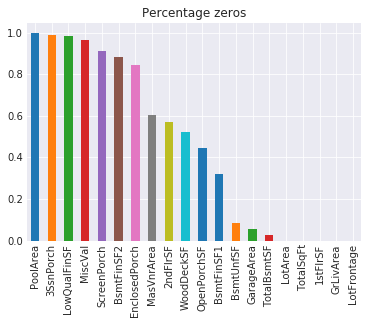

In [74]:
(X[card_cont] == 0).mean().sort_values(ascending=False).plot.bar()
plt.title('Percentage zeros')
plt.show()

There are a couple of variables with a large share of zeros. For some of these, it may be appropriate to just transform them to dummies. For example, there are barely any homes with non-zero *PoolArea*. Getting a useful estimate of the area coefficient may be difficult from such a small sample. A dummy for positive pool area could be more reliable. 

We look at variables with less than 100 non-zero observations in the training set.

In [75]:
print('Variables with less than 100 non-zero observations in training sample:\n')
print((X.loc[train_ID, card_cont] > 0).sum()[(X.loc[train_ID, card_cont] > 0).sum() < 100].sort_values())

Variables with less than 100 non-zero observations in training sample:

PoolArea         5
3SsnPorch       24
LowQualFinSF    26
MiscVal         52
dtype: int64


For these variables, we create non-zero dummies while still retaining them as potential explanatory variables in their own right. The model can then choose what's more useful. We consider the dummies only for linear models.

In [76]:
X_card_dummied = (X[['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal']] > 0).rename(
    columns={'PoolArea': 'Pool_dum', '3SsnPorch': 'SsnPorch_dum', 'LowQualFinSF': 'LowQualFin_dum', 'MiscVal': 'MiscVal_dum'}).astype(int)

X_transformed_lin.append(X_card_dummied)

Next, we plot histograms for the variables, conditional on them being non-zero.

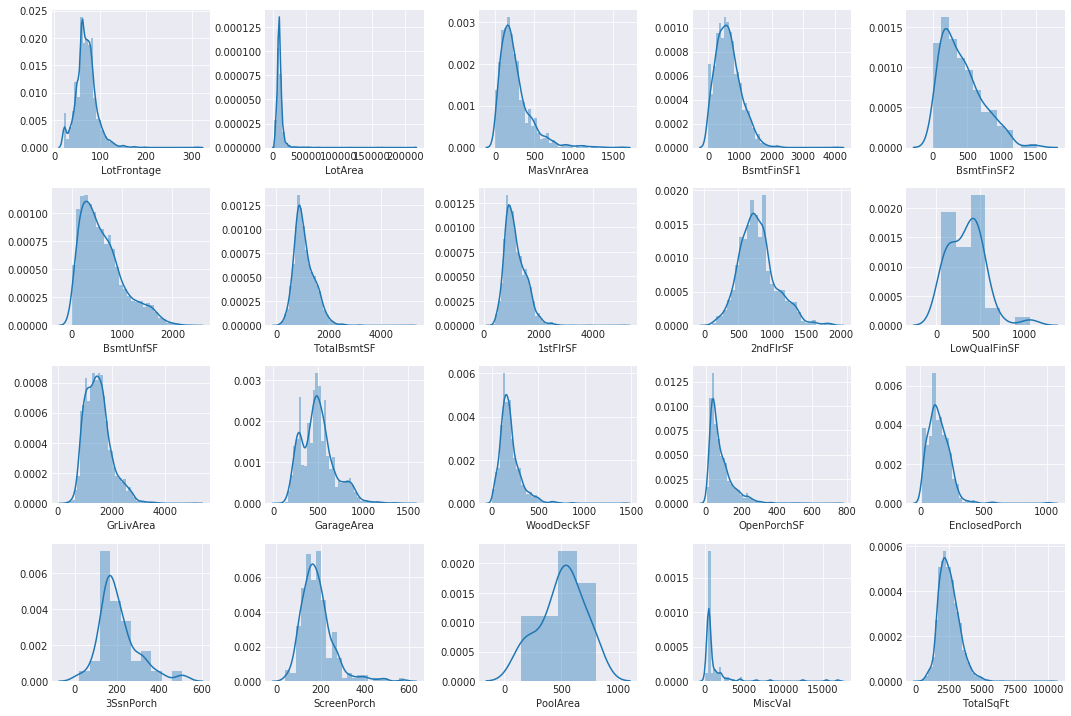

In [77]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))

for i, var in enumerate(card_cont):
    active_ax = ax.flatten()[i]
    sns.distplot(X.loc[X[var] > 0, var], ax=active_ax)

fig.tight_layout()

Many of these look right skewed which is not surprising. Looking at the same plot in logs changes that.

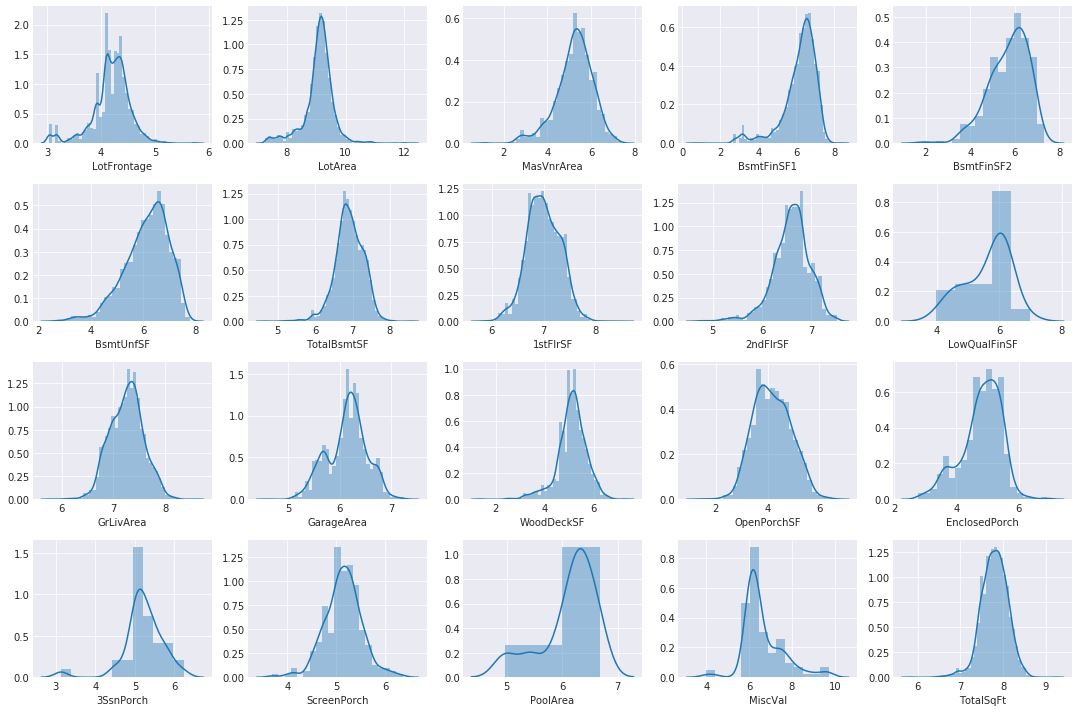

In [78]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))

for i, var in enumerate(card_cont):
    active_ax = ax.flatten()[i]
    sns.distplot(X.loc[X[var] > 0, var].apply(np.log), ax=active_ax)

fig.tight_layout()

These plots generally looks more symmetric and also yields a convenient interpretation of the parameterss as elasticities for linear regression models (regressed on log-*SalePrice*).

When taking logs, we have to take care of zero values (since $\log(0)$ is undefined). Simply setting $\log(0)$ to $0$ may be intuitive but comes at the risk of mixing ones and zeros on the original scale (since $\log(1) = 0$). However, fortunately, none of the variables actually takes the value one.

In [79]:
print('Smallest value given non-zero across continuous conditional variables: {}'.format(
X[card_cont].where(X[card_cont] > 0).min().min()))

Smallest value given non-zero across continuous conditional variables: 2.0


Thus, in setting $\log(0) = 0$ we do not risk pooling $\log(1)$ and $\log(0)$ together. 
We now perform the transformations, taking logs (mapping zeros on the original scale to zeros on the log-scale), and creating squares and cubes of the resulting log variables. 

In [80]:
X_card_log = X[card_cont].applymap(lambda x: np.log(x) if x > 0 else 0)

X_transformed_lin.append(X_card_log)
X_transformed_nonlin.append(X_card_log)

X_card_log_sq = X_card_log ** 2
X_card_log_sq.columns = X_card_log.columns + '_sq'

X_transformed_lin.append(X_card_log_sq)

X_card_log_cu = X_card_log ** 3
X_card_log_cu.columns = X_card_log.columns + '_cu'

X_transformed_lin.append(X_card_log_cu)

print('Continuous cardinal variables transformed.')

Continuous cardinal variables transformed.


##### Cardinal & Discrete

For discrete cardinal variables, we transform as follows.
* Original variables (linear and non-linear)
* Squares and cubes (linear)

In [81]:
X_card_disc_transformed = X[card_disc]

X_transformed_lin.append(X_card_disc_transformed)
X_transformed_nonlin.append(X_card_disc_transformed)

X_card_disc_transformed_sq = X_card_disc_transformed**2
X_card_disc_transformed_sq.columns = X_card_disc_transformed.columns + '_sq'

X_transformed_lin.append(X_card_disc_transformed_sq)

X_card_disc_transformed_cu = X_card_disc_transformed**3
X_card_disc_transformed_cu.columns = X_card_disc_transformed.columns + '_cu'

X_transformed_lin.append(X_card_disc_transformed_cu)

print('Discrete cardinal variables transformed.')

Discrete cardinal variables transformed.


##### Time

For time variables we proceed as follows.
* For *YearBuilt*, *YearRemodAdd* and *YrSold* we shift the variables by subtracting the most recent observed year (2010)
* *MoSold* has a somewhat symmetric shape so we symmetrize
* The newly created features (*YrBlt_to_sold*, *YrRemod_to_sold*, *GrgYrBlt_to_sold*) remain unchanged

In a linear model, subtracting the most recent year (i.e. 2010) from the yearly data yields the intrepretation that an increase by one yields a percentage increase in the *SalePrice* equal to the parameter.

We add the following as regressors.
* The shifted and symmetrized regressors directly (linear and non-linear)
* Squares and cubes (linear)

Looking at a barchart for *MoSold*, we see that more sales happen during the summer months. There is a noticeable symmetry over the month June.

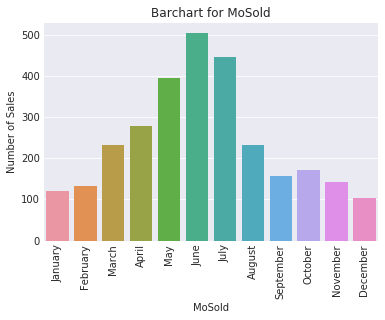

In [82]:
import calendar
tmp = X['MoSold'].value_counts().sort_index().reset_index()
tmp['index'] = tmp['index'].map(lambda x: calendar.month_name[x])
tmp.columns = ['MoSold', 'Number of Sales']
sns.barplot(x='MoSold', y='Number of Sales', data=tmp)
plt.xticks(rotation=90)
plt.title('Barchart for MoSold')
plt.show()

Assuming that prices would be impacted due to an increase in supply or demand, but not because of the month itself, it seems reasonable to impose that months with the a similar number of sales would have a similar impact on the sale price. We impose this by mapping both January and December to 0, Februrary and March to 1, etc.

In [83]:
def le_mosold(x):
    if x >=7:
        x = 12-x
    else:
        x -= 1
    return x

X_time_transformed = pd.concat([X[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']]-2010, 
                                X[['YrBlt_to_sold', 'YrRemod_to_sold', 'GrgYrBlt_to_sold']], 
                                X['MoSold'].apply(le_mosold)], axis=1)

X_transformed_lin.append(X_time_transformed)
X_transformed_nonlin.append(X_time_transformed)                                

X_time_transformed_sq = X_time_transformed**2
X_time_transformed_sq.columns = X_time_transformed.columns + '_sq'

X_transformed_lin.append(X_time_transformed_sq)

X_time_transformed_cu = X_time_transformed**3
X_time_transformed_cu.columns = X_time_transformed.columns + '_cu'

X_transformed_lin.append(X_time_transformed_cu)

print('Time variables transformed.')

Time variables transformed.


##### Final touches

We add a few final touches.
* We drop duplicated variables (linear and non-linear)
* We drop perfectly collinear variables (linear)
* We standardize the scale (linear)

In [84]:
X_transformed_lin = pd.concat(X_transformed_lin, axis=1)
X_transformed_nonlin = pd.concat(X_transformed_nonlin, axis=1)

In [85]:
X_transformed_lin = X_transformed_lin.T.drop_duplicates().T
X_transformed_nonlin = X_transformed_nonlin.T.drop_duplicates().T
print('Duplicates dropped.')

Duplicates dropped.


For  linear models, we drop perfectly collinear columns.

In [86]:
def check_full_col_rank(X, silent=False):
    rank_def = X.shape[1] - np.linalg.matrix_rank(X)
    if rank_def == 0:
        return True
    else: 
        return False
        if silent == False:
            print('Rank deficient by {}'.format(rank_def))

def find_collinearity(X, fix=True, show_comb=False):
    offset = 0
    collinear_columns = []
    
    tmp_X = X.copy()
    
    for i in range(1,tmp_X.shape[1]):
        i += offset
        if not check_full_col_rank(tmp_X.iloc[:,:i], silent=True):
            print('Collinear column: {}'.format(tmp_X.columns[i-1]))
            collinear_columns.append(tmp_X.columns[i-1])
            
            # find what causes collinearity
            tmp_coef = np.linalg.lstsq(tmp_X.iloc[:,:i-1], tmp_X.iloc[:,i-1])[0]
            tmp_coef[np.isclose(tmp_coef, 0)] = 0
            if show_comb:
                print('Linear Combination of:')
                print(pd.Series(tmp_coef, index=X.iloc[:,:i-1].columns)[tmp_coef != 0])
            
            tmp_X.drop(tmp_X.columns[i-1], inplace=True, axis=1)
            offset -=1
            
    if fix:
        print('Collinear columns dropped.')
        X.drop(collinear_columns, inplace=True, axis=1)

find_collinearity(X_transformed_lin, fix=True)

Collinear column: BsmtHalfBath_cu
Collinear column: HalfBath_cu
Collinear column: YrBlt_to_sold
Collinear column: YrRemod_to_sold
Collinear column: GrgYrBlt_to_sold
Collinear column: GarageYrBlt_cu
Collinear column: GrgYrBlt_to_sold_cu
Collinear columns dropped.


Next, we bring the variables for linear models to the same scale. We do so by dividing the variables $X$ by $SD(X | X>0)$ if the conditional standard deviation is defined. This conditional scaling can result in quite a large difference in scale compared to standard scaling. The idea is that zero values generally stand for the absence of a feature and thus have the same meaning across variables. We only normalize that part of the feature which is on a different scale across variables. (I found that this scaling performs substantially better on the LB than the more common uncoditional scaling!)

In [87]:
tmp = (X_transformed_lin.replace(0, np.nan).std() > 0)
X_transformed_lin.loc[:, tmp] /= X_transformed_lin.loc[:, tmp].replace(0, np.nan).std()
print('Linear regressors scaled.')

Linear regressors scaled.


Finally, we split into training and test data.

In [88]:
X_train_transformed_lin = X_transformed_lin.loc[train_ID, :]
X_test_transformed_lin = X_transformed_lin.loc[test_ID, :]

X_train_transformed_nonlin = X_transformed_nonlin.loc[train_ID, :]
X_test_transformed_nonlin = X_transformed_nonlin.loc[test_ID, :]
print('Data split into training and test observations.')

Data split into training and test observations.


## Modeling

We consider two models, one linear and one non-linear.
* Lasso 
* XGBoost

Beyond that, we introduce a way to correct predictions in the tails of the distribution by mean-shifting. The idea for this is as follows.
1. Generate out-of-fold predictions
2. Compute the 1st and 99th quantile of the residuals
3. Compute the mean of the residuals inside those quantiles
4. Adjust predictions below and above the quantiles by the computed means

An interesting finding is that there are several observations with which both models seem to have problems. Both models severely over-predict the *SalePrice* for these observations. It seems like there is a feature missing to capture what is going on.

In [89]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.base import clone
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV, ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
print('Packages imported')

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                     greater_is_better=False)

def get_rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true)**2))

kfold = KFold(n_splits=5, random_state=1, shuffle=True)
print('5-fold cross validation strategy defined.')

def rmse_oof_cv(model, X, y):
    # This function returns RMSEs and out-of-fold predictions across the cross validation folds.
    rmses = []
    oof_preds = []
    
    model = clone(model)
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train_fold, y_train_fold = X.iloc[train_idx, :], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx, :], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict(X_val_fold)
        rmses.append(get_rmse(y_pred, y_val_fold))
        oof_preds.append(pd.Series(y_pred, index=X_val_fold.index))
    
    rmses = np.array(rmses)
    
    return rmses, oof_preds

models = {}

Packages imported
5-fold cross validation strategy defined.


### Lasso

We set up a standard lasso model. The penalty $\alpha$ is chosen by 5 fold cross validation.

In [90]:
lasso = LassoCV(normalize=False, random_state=2, cv=5)
print('Lasso model defined.')

Lasso model defined.


#### First estimation

Next, we look at descriptive statistics of the root mean square errors across validation folds. We note that there are two levels of cross-validation going on here. One for model estimation and validation of the predictions, and one inside of that for hyper-parameter choice. This way, there is no leakage across folds.

In [91]:
lasso_rmses_cv, lasso_oof_fitted = rmse_oof_cv(lasso, X_train_transformed_lin, y_train)
print('RMSE across folds')
print('-----------------\n')
print(pd.Series(lasso_rmses_cv).describe()[1:])

RMSE across folds
-----------------

mean    0.110357
std     0.012326
min     0.097733
25%     0.098722
50%     0.110060
75%     0.120251
max     0.125020
dtype: float64


Comparing to the LB, this looks pretty good with mean and median both corresponding to a top 30 LB score. However, the standard deviation is not particularly low and the largest RMSE would put us somewhere in the $1,200$s on the LB.

#### Out of fold residual analysis

We look at the out of fold residuals in the Lasso model.

In the residual histogram we can see that there is quite a bit of left-skew and excess kurtosis. Looking at a scatterplot of true vs fitted values, the fit generally seems worse in the lower tail where there is little data. Further, we see some quite large residuals across the spectrum. Most of these relate to over-prediction of the true price, thus to negative residuals. Looking at the residual plot, we can make out a slight mean shift for residuals corresponding to fitted values below the 1st quantile and above the 99th quantile. We will explore an offset for this later on.

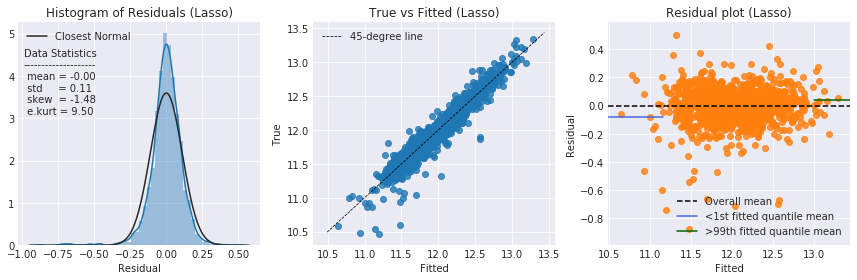

In [92]:
lasso_fitted = pd.concat(lasso_oof_fitted).sort_index().rename('Fitted')
lasso_residuals = (y_train - lasso_fitted).rename('Residual')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.distplot(lasso_residuals, fit=stats.norm, ax=ax[0])
ax[0].legend(['Closest Normal'])
ax[0].text(x=-0.99, y=3.1, 
           s='Data Statistics\n--------------------\n' + 
           ' mean = {:.2f} \n std     = {:.2f}'.format(
               lasso_residuals.mean(), lasso_residuals.std()) + 
           '\n skew  = {:.2f} \n e.kurt = {:.2f}'.format(
               lasso_residuals.skew(), lasso_residuals.kurt())
          )
ax[0].set_title('Histogram of Residuals (Lasso)')

sns.regplot(x='Fitted', y='True', ci=None, fit_reg=False,
              data=pd.concat([y_train.rename('True'), lasso_fitted], axis=1),
              ax=ax[1])
ax[1].set_title('True vs Fitted (Lasso)')
ax[1].plot(np.linspace(*ax[1].get_xlim()), np.linspace(*ax[1].get_xlim()), color='black', lw=0.75, ls='--')
ax[1].legend(['45-degree line'])
ax[1].set_xlim(ax[1].get_ylim())

sns.regplot(y='Residual', x='Fitted', ci=None, fit_reg=False,
              data=pd.concat([lasso_fitted, lasso_residuals], axis=1),
              ax=ax[2])
ax[2].set_title('Residual plot (Lasso)')
ax[2].axhline(y=lasso_residuals.mean(), xmin=0, xmax=1, color='black', lw=1.5, ls='--')

q1_fitted = lasso_fitted[lasso_fitted.rank(pct=0.01).sort_values()[:14].index]
q1_resid_mean = lasso_residuals.loc[q1_fitted.index].mean()
rel_q1 = (q1_fitted.max() - ax[2].get_xlim()[0])/(ax[2].get_xlim()[1] - ax[2].get_xlim()[0])
ax[2].axhline(y=q1_resid_mean, xmin=0, xmax=rel_q1, color='royalblue', lw=1.5, ls='-')

q99_fitted = lasso_fitted[lasso_fitted.rank(pct=0.99).sort_values()[-14:].index]
q99_resid_mean = lasso_residuals.loc[q99_fitted.index].mean()
rel_q99 = (q99_fitted.min() - ax[2].get_xlim()[0])/(ax[2].get_xlim()[1] - ax[2].get_xlim()[0])
ax[2].axhline(y=q99_resid_mean, xmin=rel_q99, xmax=1, color='darkgreen', lw=1.5, ls='-')


ax[2].legend(['Overall mean', '<1st fitted quantile mean', '>99th fitted quantile mean'])
ax[2].set_ylim((-0.99, 0.59))

fig.tight_layout()
fig.show()

##### Sidequest

Returning to the scatterplot of true vs fitted values, we show below that two seperate regression lines through the observations relating to the 1% smallest residuals and the remaining observations are almost parallel. If we had a way to identify such observations without *SalePrice* information we could likely substantially reduce the RMSE.

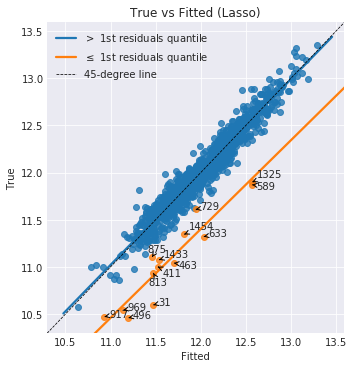

In [93]:
lasso_small_residuals = lasso_residuals.rank(pct=True) < 0.01

sns.lmplot(x='Fitted', y='True', fit_reg=True, ci=None,  hue='small', legend=False,
              data=pd.concat([y_train.rename('True'), lasso_fitted, 
                              lasso_small_residuals.rename('small')], axis=1))
plt.title('True vs Fitted (Lasso)')
plt.plot(np.linspace(*ax[1].get_xlim()), np.linspace(*ax[1].get_xlim()), color='black', lw=0.75, ls='--')
plt.legend(['$>$ 1st residuals quantile', '$\leq$ 1st residuals quantile', '45-degree line'])
plt.xlim(ax[1].get_xlim())
plt.ylim(ax[1].get_xlim())

c_x = 0.05
c_y = 0
for row in pd.concat([y_train.rename('True'), lasso_fitted], axis=1)[lasso_small_residuals].iterrows():
    if row[0] == 875:
        c_x, c_y = -0.05, 0.05
    elif row[0] == 813:
        c_x, c_y = -0.05, -0.125
    elif row[0] == 411:
        c_y = -0.1
    elif row[0] == 1433:
        c_y = 0.03
    elif row[0] in (469, 463):
        c_y = -0.05
    elif row[0] in (1454, 1325):
        c_y = 0.05
    elif row[0] == 589:
        c_y = -0.05
    plt.annotate(row[0], xy=(row[1]['Fitted'], row[1]['True']), 
                 xytext=(row[1]['Fitted'] + c_x, row[1]['True'] + c_y), 
                 arrowprops=dict(arrowstyle = '->'))
    c_x = 0.05
    c_y = 0
    
plt.show()

Considering the impact of dropping these 1% of observations (i.e., 14 obsevations) on the out-of-fold RMSE, we find a substantial difference both in mean and standard deviation (in parentheses).

In [94]:
lasso_rmses_drop_cv = np.array([get_rmse(j.mask(lasso_small_residuals), y_train[j.index].mask(lasso_small_residuals)) for j in lasso_oof_fitted])
print('With all observations, the average RMSE across folds is {:.4f} ({:.4f})'.format(lasso_rmses_cv.mean(), lasso_rmses_cv.std(ddof=1)))
print('Dropping observations relating to the smallest 1% residuals, the average RMSE across folds drops to {:.4f} ({:.4f})'.format(lasso_rmses_drop_cv.mean(), lasso_rmses_drop_cv.std(ddof=1)))

With all observations, the average RMSE across folds is 0.1104 (0.0123)
Dropping observations relating to the smallest 1% residuals, the average RMSE across folds drops to 0.0946 (0.0034)


Clearly, these 14 observations are very influential. Of course, we would always expect the RMSE to go down if we drop observations relating to large residuals. However, if instead we dropped the largest 1% of residuals, we see a much smaller impact.

In [95]:
lasso_large_residuals = lasso_residuals.rank(pct=True) >0.99
tmp = np.array([get_rmse(j.mask(lasso_large_residuals), y_train[j.index].mask(lasso_large_residuals)) for j in lasso_oof_fitted])
print('Without the largest 1% of residual observations, the average RMSE across folds is {:.4f} ({:.4f})'.format(tmp.mean(), tmp.std(ddof=1)))

Without the largest 1% of residual observations, the average RMSE across folds is 0.1059 (0.0124)


Unfortunately, since there are only 14 such observations, it is hard to find an auxiliary model that does better than chance in detecting them and so far I wasn't successful in finding one (yet).

#### Offsetting the tails

We now explore the tail offset brushed over in the residual plot above. To investigate its effect without leakage, we need to add another layer of cross-validation. We proceed as follows.

<img src="https://user-images.githubusercontent.com/25103918/40367385-3fd8b1e2-5da7-11e8-8a5d-d7e75fcde471.png" alt="Illustration of cross validation strategy" width="600" height="600"/>

Thus, the offset procedure does not have a direct effect on model estimation. Rather, it is a step performed afterwards. Basically, this is a form of meta-modeling. Meta-models are described well in the kernels by [Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) and [Arun Godwin Patel](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook) mentioned in the introduction. We are going to revisit meta-models later on for model combination.

In [96]:
def double_cv(model, X, y):
    
    oof_predictions = []
    val_fold_predictions = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train_fold, y_train_fold = X.iloc[train_idx, :], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx, :], y.iloc[val_idx]

        oof_preds = pd.concat(rmse_oof_cv(model, X_train_fold, y_train_fold)[1])

        oof_predictions.append(oof_preds)

        tmp = clone(model).fit(X_train_fold, y_train_fold)

        val_fold_preds = pd.Series(tmp.predict(X_val_fold), index=X_val_fold.index)

        val_fold_predictions.append(val_fold_preds) 
    
    return oof_predictions, val_fold_predictions

def offset_tails(oof, val_f):
    tmp_oof_pred = []
    tmp_val_pred = []
    
    offsets_low = []
    offsets_high = []
    
    for i in range(len(oof)):
        tmp_oof = oof[i].copy()
        
        high_q = tmp_oof.quantile(0.99)
        low_q = tmp_oof.quantile(0.01)
        
        offset_low = (y_train[tmp_oof.index] - tmp_oof)[tmp_oof < low_q].mean()
        offset_high = (y_train[tmp_oof.index] - tmp_oof)[tmp_oof > high_q].mean()
    
        offsets_low.append(offset_low)
        offsets_high.append(offset_high)
        
        tmp_oof.loc[tmp_oof > high_q] += offset_high
        tmp_oof.loc[tmp_oof < low_q] += offset_low
        
        tmp_oof_pred.append(tmp_oof)
        
        tmp_val_f = val_f[i].copy()
        tmp_val_f.loc[tmp_val_f > high_q] += offset_high
        tmp_val_f.loc[tmp_val_f < low_q] += offset_low
        tmp_val_pred.append(tmp_val_f)
    
    return tmp_oof_pred, tmp_val_pred, np.array(offsets_low), np.array(offsets_high)

def rmse_from_val_preds(val_preds, y):
    return np.array([get_rmse(y[p.index], p) for p in val_preds])

We can see that the average RMSE drops by offsetting. Similarly, the largest RMSE and the standard deviation decrease. Offsets for the lower tail of the fitted values are negative while those for the upper tail are positive in line what we saw in the residual plot above

In [97]:
lasso_oof_predictions, lasso_val_f_predictions = double_cv(lasso, X_train_transformed_lin, y_train)

lasso_oof_offset, lasso_val_offset, lasso_offsets_low, lasso_offsets_high = offset_tails(lasso_oof_predictions, lasso_val_f_predictions)

lasso_offset_results = pd.DataFrame([lasso_rmses_cv, rmse_from_val_preds(lasso_val_offset, y_train), 
                                     lasso_offsets_low, lasso_offsets_high], 
                                    index=['RMSE', 'RMSE/Offset', 'Offset 1st', 'Offset 99th']).T

lasso_offset_results.describe().iloc[1:, :]

,RMSE,RMSE/Offset,Offset 1st,Offset 99th
mean,0.110357,0.109962,-0.073536,0.040192
std,0.012326,0.012044,0.026667,0.021406
min,0.097733,0.097968,-0.105538,0.007220
25%,0.098722,0.098810,-0.081876,0.030398
50%,0.110060,0.108269,-0.074376,0.049729
75%,0.120251,0.121792,-0.074181,0.054973
max,0.125020,0.122970,-0.031707,0.058642


We point out that offsets are compute based models estimated on only about 2/3 of the training data due to the two levels of 5-fold cross validation.

#### The full model

Next, we fit the Lasso model to the full training data and look at its estimates.

In [98]:
lasso.fit(X_train_transformed_lin, y_train)
print('The chosen alpha for the Lasso is {:.5f}.'.format(lasso.alpha_))
print('The number of retained regressors is is {} out of {}.\n'.format(np.sum(lasso.coef_ != 0), X_train_transformed_lin.shape[1]))

The chosen alpha for the Lasso is 0.00069.
The number of retained regressors is is 105 out of 314.



The model drops a large number of regressors, doing its job. Looking at the retained regressors, the largest price bump comes from the neighborhood *Crawford*. This is followed by the sale of a new home, condition, quality and *TotalSftFt_cu*. Generally, location plays a big role (location, location, location!) since many neighborhood dummies enter. The largest discount comes from the neighborhood *IDOTRR* and *MSSubClass_30*. A strange artifact is that the number of *KitchenAbvGr* enters with a negative coefficient.

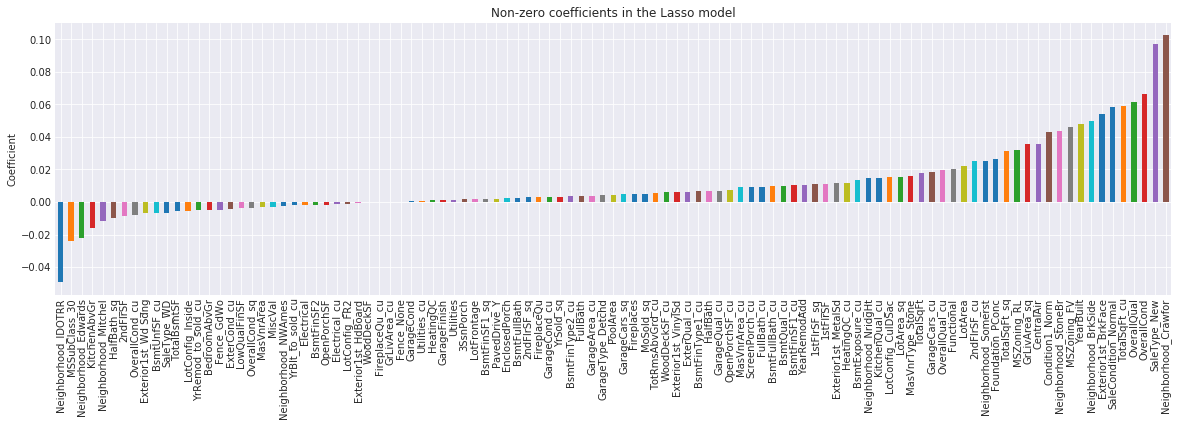

In [99]:
lasso_coefs = pd.Series(lasso.coef_, X_train_transformed_lin.columns)[lasso.coef_ != 0].sort_values()
lasso_coefs.plot.bar(figsize=(20,5))
plt.title('Non-zero coefficients in the Lasso model')
plt.ylabel('Coefficient')
plt.show()

Finally, we add the Lasso to our model collection for later use.

In [100]:
models['lasso'] = lasso
print('Lasso added to model collection.')

Lasso added to model collection.


### XGBoost
As a second non-linear model, we consider XGBoost. This tree-based ensamble model has many more hyperparameters and is thus much more computationally intensive to tune.

We write a class for XGBoost hyperparameter optimization mostly following [this guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In [101]:
class XGBRegressorCV(object):
    
    def __init__(self, random_state=0, n_jobs=-1, cv=None, scoring=None):
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.cv = cv
        self.scoring = scoring
    
    def fit(self, X, y):
        xgb = XGBRegressor(random_state=self.random_state, n_jobs=self.n_jobs, 
                           max_depth=5, min_child_weight=1, gamma=0, 
                           subsample=0.8, colsample_bytree=0.8)

        # n_estimators
        grid = GridSearchCV(xgb, param_grid={'n_estimators': np.arange(25, 500, 25)},
                           cv=self.cv, scoring=self.scoring)

        xgb = grid.fit(X, y).best_estimator_

        # max_depth and min_child_weight
        grid = GridSearchCV(xgb, param_grid={
            'max_depth': np.arange(1, 10, 1), 'min_child_weight': np.arange(1,10, 1)
        }, cv=self.cv, scoring=self.scoring)

        xgb = grid.fit(X, y).best_estimator_

        # gamma
        grid = GridSearchCV(xgb, param_grid={'gamma': np.arange(0,0.5, 0.1)}, 
                           cv=self.cv, scoring=self.scoring)

        xgb = grid.fit(X, y).best_estimator_

        ## n_estimators again
        #grid = GridSearchCV(xgb, param_grid={
        #    'n_estimators': np.arange(xgb.n_estimators-150, xgb.n_estimators+150, 10)},
        #                   cv=self.cv, scoring=self.scoring)
        #
        #xgb = grid.fit(X, y).best_estimator_

        # subsample and colsample_bytree
        grid = GridSearchCV(xgb, param_grid={
            'subsample': np.arange(0.1, 1, 0.1), 'colsample_bytree': np.arange(0.1, 1, 0.1)
        }, cv=self.cv, scoring=self.scoring)

        xgb = grid.fit(X, y).best_estimator_

        # reg_alpha and reg_lambda
        grid = GridSearchCV(xgb, param_grid={
            'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05], 'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
        }, cv=self.cv, scoring=self.scoring)

        xgb = grid.fit(X, y).best_estimator_
        
        # increase n_estimators and lower learning rate
        grid = GridSearchCV(xgb, param_grid={
            'learning_rate': [xgb.learning_rate/2], 'n_estimators': np.arange(2*xgb.n_estimators-150, 2*xgb.n_estimators+150, 25)
        }, cv=self.cv, scoring=self.scoring)

        final_grid = grid.fit(X, y)
        
        self.best_estimator_ = final_grid.best_estimator_
        
        return final_grid
    
    def predict(self, X):
        return self.best_estimator_.predict(X)
    
print('XGBoost tuning class defined.')

XGBoost tuning class defined.


Since training here is computationally expensive, we allow for some leakage between cross-validation folds by tuning parameter on the full data set first and then using these optimal hyperparameters from here on out. Thus, information from hyperparameter tuning does leak across folds here. 

In [102]:
xgb_cv = XGBRegressorCV(random_state=3, cv=kfold, scoring=rmse_scorer)
xgb_cv.fit(X_train_transformed_nonlin, y_train)
print('XGBoost hyperparameters optimized.\n')
xgb = xgb_cv.best_estimator_

tmp = xgb.get_xgb_params()

print('Hyperparameters')
print('---------------')
for para in ('n_estimators', 'learning_rate', 'gamma', 'max_depth', 'min_child_weight',
             'reg_alpha', 'reg_lambda', 'subsample', 'colsample_bytree'):
    print('{}: {}'.format(para, tmp[para]))

XGBoost hyperparameters optimized.

Hyperparameters
---------------
n_estimators: 1025
learning_rate: 0.05
gamma: 0.0
max_depth: 3
min_child_weight: 2
reg_alpha: 0.001
reg_lambda: 1
subsample: 0.8
colsample_bytree: 0.8


In [103]:
xgb_rmses_cv, xgb_oof_fitted = rmse_oof_cv(xgb, X_train_transformed_nonlin, y_train)
print('RMSE across folds')
print('-----------------\n')
print(pd.Series(xgb_rmses_cv).describe()[1:])

RMSE across folds
-----------------

mean    0.114419
std     0.011378
min     0.097785
25%     0.110234
50%     0.115483
75%     0.120591
max     0.128000
dtype: float64


The average RMSE of XGBoost is somewhat larger than that of the Lasso (0.1104) even though we allowed for some leakage across folds here. In contrast, the standard deviation is lower.

#### Ouf of fold residual analysis
Now we look at the residual analysis for XGBoost.

Histogram, true vs fitted, and residual plot all look similar to those of the Lasso model above. However, skew and excess kurtosis of the residuals is somewhat lower. However, we cannot exclude the possiblity that this is just a result of leakage across folds. Looking at the true vs fitted plot, we still see a number of observations substantially below the 45-degree line. In the residual plot, averages below the 1st and above the 99th percentile of fitted values are negative and positive, respectively. This, too, matches the observations from the Lasso residuals.

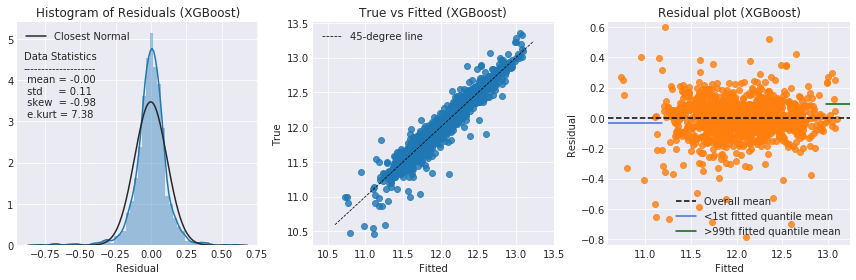

In [104]:
xgb_fitted = pd.concat(xgb_oof_fitted).sort_index().rename('Fitted')
xgb_residuals = (y_train - xgb_fitted).rename('Residual')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.distplot(xgb_residuals, fit=stats.norm, ax=ax[0])
ax[0].legend(['Closest Normal'])
ax[0].text(x=-0.9, y=3.1, 
           s='Data Statistics\n--------------------\n' + 
           ' mean = {:.2f} \n std     = {:.2f}'.format(
               xgb_residuals.mean(), xgb_residuals.std()) + 
           '\n skew  = {:.2f} \n e.kurt = {:.2f}'.format(
               xgb_residuals.skew(), xgb_residuals.kurt())
          )
ax[0].set_title('Histogram of Residuals (XGBoost)')

sns.regplot(x='Fitted', y='True', ci=None, fit_reg=False,
              data=pd.concat([y_train.rename('True'), xgb_fitted], axis=1),
              ax=ax[1])
ax[1].set_title('True vs Fitted (XGBoost)')
ax[1].plot(np.linspace(*ax[1].get_xlim()), np.linspace(*ax[1].get_xlim()), color='black', lw=0.75, ls='--')
ax[1].legend(['45-degree line'])
ax[1].set_xlim(ax[1].get_ylim())

sns.regplot(y='Residual', x='Fitted', ci=None, fit_reg=False,
              data=pd.concat([xgb_fitted, xgb_residuals], axis=1),
              ax=ax[2])
ax[2].set_title('Residual plot (XGBoost)')
ax[2].axhline(y=xgb_residuals.mean(), xmin=0, xmax=1, color='black', lw=1.5, ls='--')

q1_fitted = xgb_fitted[xgb_fitted.rank(pct=0.01).sort_values()[:14].index]
q1_resid_mean = xgb_residuals.loc[q1_fitted.index].mean()
rel_q1 = (q1_fitted.max() - ax[2].get_xlim()[0])/(ax[2].get_xlim()[1] - ax[2].get_xlim()[0])
ax[2].axhline(y=q1_resid_mean, xmin=0, xmax=rel_q1, color='royalblue', lw=1.5, ls='-')

q99_fitted = xgb_fitted[xgb_fitted.rank(pct=0.99).sort_values()[-14:].index]
q99_resid_mean = xgb_residuals.loc[q99_fitted.index].mean()
rel_q99 = (q99_fitted.min() - ax[2].get_xlim()[0])/(ax[2].get_xlim()[1] - ax[2].get_xlim()[0])
ax[2].axhline(y=q99_resid_mean, xmin=rel_q99, xmax=1, color='darkgreen', lw=1.5, ls='-')


ax[2].legend(['Overall mean', '<1st fitted quantile mean', '>99th fitted quantile mean'])
ax[2].set_ylim((-0.84, 0.63))

fig.tight_layout()
fig.show()

##### Sidequest revisited

Taking a closer look at the outliers again, we see quite some overlap across models. Yet, the outliers are not entirely identical which gives hope for model averaging.

Number of overlapping outliers between Lasso and XGBoost: 10
------------------------------------------------------------



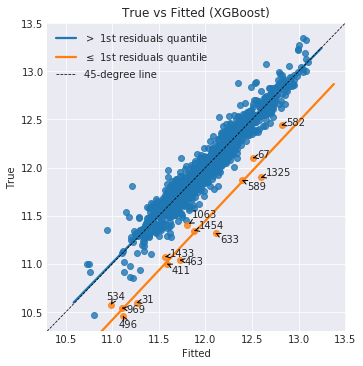

In [105]:
xgb_small_residuals = xgb_residuals.rank(pct=True) < 0.01

tmp = pd.concat([lasso_small_residuals, xgb_small_residuals], axis=1).all(axis=1).sum()
print('Number of overlapping outliers between Lasso and XGBoost: {}'.format(tmp))
print('------------------------------------------------------------\n')


sns.lmplot(x='Fitted', y='True', fit_reg=True, ci=None,  hue='small', legend=False,
              data=pd.concat([y_train.rename('True'), xgb_fitted, 
                              xgb_small_residuals.rename('small')], axis=1))
plt.title('True vs Fitted (XGBoost)')
plt.plot(np.linspace(*ax[1].get_xlim()), np.linspace(*ax[1].get_xlim()), color='black', lw=0.75, ls='--')
plt.legend(['$>$ 1st residuals quantile', '$\leq$ 1st residuals quantile', '45-degree line'])
plt.xlim(ax[1].get_xlim())
plt.ylim(ax[1].get_xlim())

c_x = 0.05
c_y = 0
for row in pd.concat([y_train.rename('True'), xgb_fitted], axis=1)[xgb_small_residuals].iterrows():
    if row[0] == 534:
        c_x, c_y = -0.05, 0.05
    elif row[0] == 589:
        c_y = -0.1
    elif row[0] in (411, 633):
        c_y = -0.1
    elif row[0] == 1063:
        c_y = 0.07
    elif row[0] in (969, 463):
        c_y = -0.05
    elif row[0] in (1454, 1325):
        c_y = 0.02
    elif row[0] == 496:
        c_x, c_y = -0.05, -0.125
    plt.annotate(row[0], xy=(row[1]['Fitted'], row[1]['True']), 
                 xytext=(row[1]['Fitted'] + c_x, row[1]['True'] + c_y), 
                 arrowprops=dict(arrowstyle = '->'))
    c_x = 0.05
    c_y = 0
    
plt.show()

#### Offsetting the tails

Just as for the Lasso, we can offset the tails of the XGBoost predictions. Now, offsetting actually yields a worse average RMSE. Standard deviation and maximum RMSE again go down but generally a less consistent picture arises. This is also reflected in  the fact that offsets for the 1st quantile of the fitted values are quite volatile. Indeed, for the largest offset the sign changes from negative to positive.

In [106]:
xgb_oof_predictions, xgb_val_f_predictions = double_cv(xgb, X_train_transformed_nonlin, y_train)

xgb_oof_offset, xgb_val_offset, xgb_offsets_low, xgb_offsets_high = offset_tails(xgb_oof_predictions, xgb_val_f_predictions)

xgb_offset_results = pd.DataFrame([xgb_rmses_cv, rmse_from_val_preds(xgb_val_offset, y_train), 
                                     xgb_offsets_low, xgb_offsets_high], 
                                    index=['RMSE', 'RMSE/Offset', 'Offset 1st', 'Offset 99th']).T

xgb_offset_results.describe().iloc[1:, :]

,RMSE,RMSE/Offset,Offset 1st,Offset 99th
mean,0.114419,0.114945,-0.096837,0.074426
std,0.011378,0.009713,0.049020,0.037963
min,0.097785,0.102537,-0.173216,0.028745
25%,0.110234,0.107988,-0.113610,0.040871
50%,0.115483,0.118269,-0.080224,0.084062
75%,0.120591,0.118766,-0.070645,0.104922
max,0.128000,0.127165,-0.046490,0.113530


#### The full model

Finally, we look at feature importance in the full model.

Here, *LotArea* is the most important feature. Above that, the top nine spots are all taken by some kind of measure for area. *Neighborhood* comes in on tenth place.

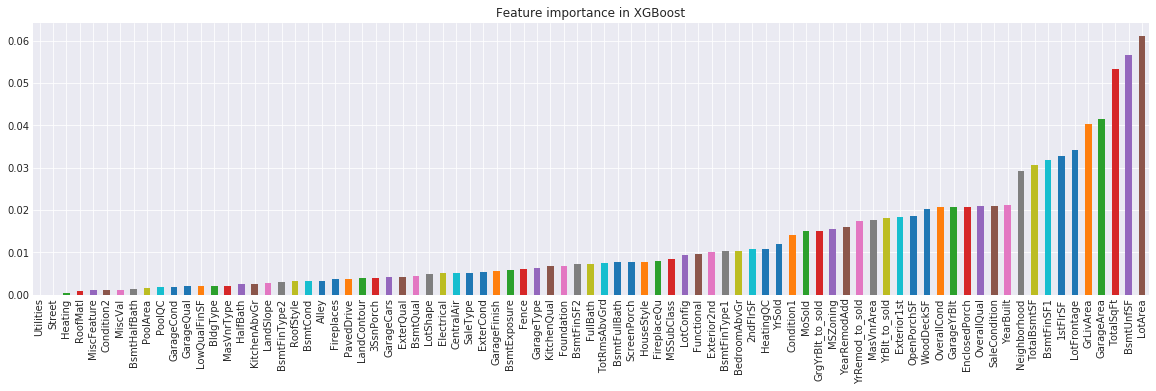

In [107]:
pd.Series(xgb.feature_importances_, index=X_train_transformed_nonlin.columns).sort_values().plot.bar(figsize=(20,5))
plt.title('Feature importance in XGBoost')
plt.show()

In [108]:
models['xgb'] = xgb
print('XGBoost added to model collection.')

XGBoost added to model collection.


## Combining Models

The next step is to combine the two models in a useful way. This works better the more different the two models are. Looking at the residual of both models, we can actually see a quite high positive correlation. Still, the correlation also isn't equal to one so there is hope for some improvements by model combination here.

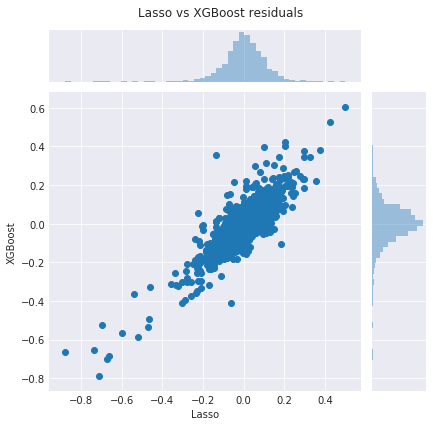

In [109]:
model_residuals = pd.concat([lasso_residuals.rename('Lasso'), xgb_residuals.rename('XGBoost')], axis=1)
sns.jointplot(x='Lasso', y='XGBoost', data=model_residuals)
plt.subplots_adjust(top=0.925)
plt.suptitle('Lasso vs XGBoost residuals')
plt.show()

We combine models in two different ways.
* Simple averaging
* Weighted averaging with weights selected by a least squares meta-model

Within each, we further look at four different sets of regressors.
* Predictions without offset
* Predictions with offset only for the Lasso predictions
* Predictions with offset only for the XGBoost predictions
* Predictions with offset for both models

Finally, we consider the impact of averaging across the predictions of the best combination in each category.

In [110]:
def fit_meta_model(meta_model, oof1, oof2, val1, val2):
    def get_regressors(y1, y2):
        return [pd.concat([p, y2[i]], axis=1) for i, p in enumerate(y1)]
    
    meta_rmse = []
    meta_oof_predictions = []
    meta_val_fold_predictions = []
    meta_weights = []

    for i,p in enumerate(get_regressors(oof1, oof2)):
        meta_model.fit(p, y_train[p.index])
        try:
            meta_w = pd.Series(meta_model.coef_, index=p.columns)
        except AttributeError:
            meta_w = pd.Series(meta_model.feature_importances_, index=p.columns)
        meta_weights.append(meta_w)

        meta_oof_predictions.append(pd.Series(meta_model.predict(p), index=p.index))

        q = get_regressors(val1, val2)
        meta_pred = pd.Series(meta_model.predict(q[i]), index=q[i].index)
        try:
            meta_rmse.append(get_rmse(meta_pred, y_train[q[i].index]))
        except KeyError:
            pass
        meta_val_fold_predictions.append(pd.Series(meta_pred, index=q[i].index))

    return meta_rmse, meta_weights, meta_oof_predictions, meta_val_fold_predictions

### Model Averaging

We take means over the predictions of the individual models.

We see that averaging reduces the RMSE compared to the individual model performance. Offsetting the tails has a further beneficial impact. The smallest average RMSE is given by predictions with tail offsets only for the Lasso model. This is the winning model from model averaging. Still, it is difficult to choose the best model with confidence. For example, the smallest maximum RMSE arises by averaging both offset models.

In [111]:
average_val_fold_pred = [pd.concat([p, xgb_val_f_predictions[i]], axis=1).mean(axis=1) for i, p in enumerate(lasso_val_f_predictions)]
average_val_fold_pred_offset = [pd.concat([p, xgb_val_offset[i]], axis=1).mean(axis=1) for i, p in enumerate(lasso_val_offset)]
average_val_fold_pred_offset_lasso = [pd.concat([p, xgb_val_f_predictions[i]], axis=1).mean(axis=1) for i, p in enumerate(lasso_val_offset)]
average_val_fold_pred_offset_xgb = [pd.concat([p, xgb_val_offset[i]], axis=1).mean(axis=1) for i, p in enumerate(lasso_val_f_predictions)]

pd.DataFrame(
    {'Lasso': [get_rmse(p, y_train[p.index]) for p in lasso_val_f_predictions],
     'XGBoost': [get_rmse(p, y_train[p.index]) for p in xgb_val_f_predictions],
     'Lasso/Offset': [get_rmse(p, y_train[p.index]) for p in lasso_val_offset],
     'XGBoost/Offset': [get_rmse(p, y_train[p.index]) for p in xgb_val_offset],
     'Avg': [get_rmse(p, y_train[p.index]) for p in average_val_fold_pred],
     'Avg/Offset Lasso': [get_rmse(p, y_train[p.index]) for p in average_val_fold_pred_offset_lasso],
     'Avg/Offset XGBoost': [get_rmse(p, y_train[p.index]) for p in average_val_fold_pred_offset_xgb],
     'Avg/Offset': [get_rmse(p, y_train[p.index]) for p in average_val_fold_pred_offset],
    }
).describe().iloc[1:, :]

,Lasso,XGBoost,Lasso/Offset,XGBoost/Offset,Avg,Avg/Offset Lasso,Avg/Offset XGBoost,Avg/Offset
mean,0.110357,0.114419,0.109962,0.114945,0.108169,0.107838,0.108075,0.107961
std,0.012326,0.011378,0.012044,0.009713,0.011709,0.011227,0.011346,0.010917
min,0.097733,0.097785,0.097968,0.102537,0.093416,0.093819,0.094773,0.095507
25%,0.098722,0.110234,0.098810,0.107988,0.100125,0.099612,0.098967,0.098514
50%,0.110060,0.115483,0.108269,0.118269,0.111241,0.111464,0.111251,0.110579
75%,0.120251,0.120591,0.121792,0.118766,0.112465,0.111976,0.112215,0.113156
max,0.125020,0.128000,0.122970,0.127165,0.123600,0.122320,0.123168,0.122051


### OLS Meta-Model

Now we consider weighting by a standard least squares regression.

Interestingly, this does worse than simple model averaging in terms of average RMSE in each regressor category. The best performing meta-model here is the one which offsets both Lasso and XGBoost predictions. This model also peforms better in terms of median RMSE than the best model averaging choice.

In [112]:
meta_ols_rmse = fit_meta_model(LinearRegression(fit_intercept=False), lasso_oof_predictions, xgb_oof_predictions, lasso_val_f_predictions, xgb_val_f_predictions)[0]
meta_ols_rmse_offset, meta_ols_weights_offset, _, meta_ols_val_fold_offset = fit_meta_model(LinearRegression(fit_intercept=False), lasso_oof_offset, xgb_oof_offset, lasso_val_offset, xgb_val_offset)
meta_ols_rmse_offset_xgb = fit_meta_model(LinearRegression(fit_intercept=False), lasso_oof_predictions, xgb_oof_offset, lasso_val_f_predictions, xgb_val_offset)[0]
meta_ols_rmse_offset_lasso= fit_meta_model(LinearRegression(fit_intercept=False), lasso_oof_offset, xgb_oof_predictions, lasso_val_offset, xgb_val_f_predictions)[0]

pd.DataFrame([meta_ols_rmse, meta_ols_rmse_offset_lasso, meta_ols_rmse_offset_xgb, meta_ols_rmse_offset],
             index=['Meta OLS', 'Meta OLS/Offset Lasso', 'Meta OLS/Offset XGBoost', 'Meta OLS/Offset']).T.describe().iloc[1:, :]

,Meta OLS,Meta OLS/Offset Lasso,Meta OLS/Offset XGBoost,Meta OLS/Offset
mean,0.108686,0.108273,0.108364,0.108176
std,0.012097,0.011644,0.012037,0.011638
min,0.094311,0.094943,0.094547,0.095473
25%,0.098659,0.098046,0.097932,0.097374
50%,0.110997,0.109656,0.110288,0.109224
75%,0.115935,0.116888,0.115860,0.117117
max,0.123526,0.121835,0.123194,0.121693


Looking at the weights, the meta-model attributes on average 70% weight to the (offset) Lasso predictions and 30% to the offset XGBoost predictions.

In [113]:
print('Weights')
print('-------\n')
pd.DataFrame(meta_ols_weights_offset).rename(columns={0: 'Lasso/Offset', 1: 'XGBoost/Offset'}).describe().iloc[1:, :]

Weights
-------



,Lasso/Offset,XGBoost/Offset
mean,0.699132,0.300875
std,0.066903,0.066940
min,0.648396,0.189890
25%,0.654175,0.287390
50%,0.670427,0.329628
75%,0.712610,0.345859
max,0.810052,0.351612


### Averaging Meta-Models

If we take the average over predictions of the two best meta-models, we can bring down the RMSE a bit more. However, we note that we also chose the best performing model in each category (average, Meta OLS) for these folds. However, to avoid a third layer of cross-validation we simply decide to use this model since we don't have any evidence against it and it might further increase robustness. We note that averaging the two models does not simply give us the same results as if we averaged the weights in each fold. This is because we don't use the same meta-regressor for the two models.

In [114]:
meta_comb_rmse = []
meta_comb_val_fold_predictions = []

for i in range(len(average_val_fold_pred_offset_lasso)):
    meta_comb_pred = pd.concat([average_val_fold_pred_offset_lasso[i],
                                meta_ols_val_fold_offset[i]
                               ], axis=1).mean(axis=1)
    meta_comb_rmse.append(get_rmse(y_train[meta_comb_pred.index], meta_comb_pred))
    meta_comb_val_fold_predictions.append(meta_comb_pred)


meta_comb_rmse = np.array(meta_comb_rmse)

print('RMSE across folds')
print('-----------------\n')
print(pd.Series(meta_comb_rmse).describe()[1:])

RMSE across folds
-----------------

mean    0.107761
std     0.011258
min     0.094458
25%     0.098369
50%     0.110231
75%     0.113927
max     0.121822
dtype: float64


Looking at the true vs fitted plots of the Lasso, XGBoost, and combined Meta-model, it is somewhat difficult to see large differences. Still, the fit at the upper tail seems improved and perhaps there is also some improvement at the lower tail visible. 

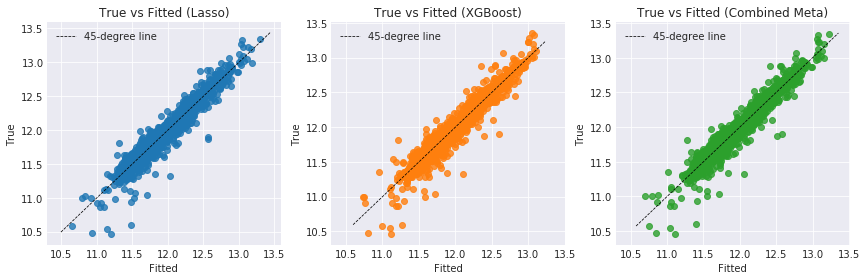

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.regplot(x='Fitted', y='True', ci=None, fit_reg=False,
              data=pd.concat([y_train.rename('True'), lasso_fitted], axis=1),
              ax=ax[0])
ax[0].set_title('True vs Fitted (Lasso)')
ax[0].plot(np.linspace(*ax[0].get_xlim()), np.linspace(*ax[0].get_xlim()), color='black', lw=0.75, ls='--')
ax[0].legend(['45-degree line'])
ax[0].set_xlim(ax[0].get_ylim())

sns.regplot(x='Fitted', y='True', ci=None, fit_reg=False,
              data=pd.concat([y_train.rename('True'), xgb_fitted], axis=1),
              ax=ax[1])
ax[1].set_title('True vs Fitted (XGBoost)')
ax[1].plot(np.linspace(*ax[1].get_xlim()), np.linspace(*ax[1].get_xlim()), color='black', lw=0.75, ls='--')
ax[1].legend(['45-degree line'])
ax[1].set_xlim(ax[1].get_ylim())

meta_comb_fitted = pd.concat(meta_comb_val_fold_predictions).rename('Fitted')

sns.regplot(x='Fitted', y='True', ci=None, fit_reg=False,
              data=pd.concat([y_train.rename('True'), meta_comb_fitted], axis=1),
              ax=ax[2])
ax[2].set_title('True vs Fitted (Combined Meta)')
ax[2].plot(np.linspace(*ax[2].get_xlim()), np.linspace(*ax[2].get_xlim()), color='black', lw=0.75, ls='--')
ax[2].legend(['45-degree line'])
ax[2].set_xlim(ax[2].get_ylim())

fig.tight_layout()

## Test Set Predictions
Finally, we generate predictions for submission.

First, we get the out of fold predictions and the weights.

In [116]:
final_oof_preds = {}
final_oof_preds['lasso'] = pd.concat(rmse_oof_cv(models['lasso'], X_train_transformed_lin, y_train)[1])
final_oof_preds['xgb'] = pd.concat(rmse_oof_cv(models['xgb'], X_train_transformed_nonlin, y_train)[1])

final_oof_preds = pd.DataFrame(final_oof_preds)
print('Final out of fold predictions generated.')

test_pred = {}
test_pred['lasso'] = lasso.predict(X_test_transformed_lin)
test_pred['xgb'] = xgb.predict(X_test_transformed_nonlin)

test_pred = pd.DataFrame(test_pred, index=X_test_transformed_lin.index)
print('Test set prediction of Lasso and XGBoost generated.')

final_lasso_oof_offset, test_pred_lasso_offset, _, _ = offset_tails([final_oof_preds['lasso']], [test_pred['lasso']])
final_xgb_oof_offset, test_pred_xgb_offset, _, _ = offset_tails([final_oof_preds['xgb']], [test_pred['xgb']])

final_oof_offset = pd.concat([final_lasso_oof_offset[0], final_xgb_oof_offset[0]], axis=1)
test_pred_offset = pd.concat([test_pred_lasso_offset[0], test_pred_xgb_offset[0]], axis=1)
print('Offsets for Lasso and XGBoost predictions computed.')

test_pred_average = pd.concat([test_pred_offset['lasso'], test_pred['xgb']], axis=1).mean(axis=1)
print('Model average test set predictions computed.')

_, final_ols_w, _, test_pred_meta_ols = fit_meta_model(LinearRegression(fit_intercept=False), 
                                                       [final_oof_offset['lasso']], [final_oof_offset['xgb']], 
                                                       [test_pred_offset['lasso']], [test_pred_offset['xgb']])
print('Meta-OLS predictions computed.\n')

print('Weights of Meta-OLS')
print('-------------------')
final_ols_w = final_ols_w[0]
final_ols_w.index = ['Lasso/Offset', 'XGBoost/Offset']
print(final_ols_w)
print('\n')

test_preds = pd.concat([test_pred_average, test_pred_meta_ols[0]], axis=1).mean(axis=1)
print('\nMeta-model predictions averaged')

test_predictions = np.exp(test_preds).rename('SalePrice')
print('\nPredictions transformed to original scale.')

Final out of fold predictions generated.
Test set prediction of Lasso and XGBoost generated.
Offsets for Lasso and XGBoost predictions computed.
Model average test set predictions computed.
Meta-OLS predictions computed.

Weights of Meta-OLS
-------------------
Lasso/Offset      0.610833
XGBoost/Offset    0.389101
dtype: float64



Meta-model predictions averaged

Predictions transformed to original scale.


Before we are done, we look at the prediction for the outlier with more than 4000sqft *GrLivArea* in the test set. 

In [117]:
print('The prediction for the large home is ${:.0f}'.format(test_predictions[2550]))

The prediction for the large home is $799893


As discussed at the beginning. We know that this is a partial sale so this price is likely to high. Instead, we set it to the average price of the two large partial sales computed earlier.

In [118]:
test_predictions[2550] = avg_large_partial_price
print('Large home prediction adjusted to ${:.0f}.'.format(avg_large_partial_price))

Large home prediction adjusted to $172375.


Finally, we save the predictions.

In [119]:
test_predictions.to_csv('predictions.csv', header=True)
print('Predictions saved.')

Predictions saved.


And that's it :).